# Imports

In [1]:
# Standard libraries
import math
import random
from collections import Counter

# External libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG19
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "./data/Dataset"

##  Name of classes 
CLASSES = ['Mild-Demented',
           'Moderate-Demented',
           'Non-Demented',
           'VeryMild-Demented']

# Load img, Rescale, One Hot Encoding

In [3]:
img_target_size = (78, 94)
img_size = (78, 94, 3)

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=img_target_size,batch_size=6426, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6426 images belonging to 4 classes.


In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6426, 78, 94, 3)
Labels shape :	 (6426, 4)


In [6]:
#   Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 90), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


# Split dataset into Train and Test

In [7]:
#   20% split to validation and 80% split to train set
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Apply Smote-ENN

In [8]:
# Apply SMOTEENN to the flattened data
X_se, y_se = SMOTEENN().fit_resample(X_train.reshape(-1, 78 * 94 * 3), y_train)

# Reshape back to the original image dimensions
X_se = X_se.reshape(-1, 78, 94, 3)

# Split dataset into Train and Validation

In [9]:
#   20% split to test from 80% of train and 60% remains in train set
X_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2)
X_se_train, X_se_val, y_se_train, y_se_val = train_test_split(X_se,y_se, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")
print("Number of samples for training before SMOTEENN:\t", sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Number of samples for training after SMOTEENN:\t", sorted(Counter(np.argmax(y_se_train, axis=1)).items()))
print("Number of samples for validation before SMOTEENN:\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Number of samples for validation after SMOTEENN:\t",sorted(Counter(np.argmax(y_se_val, axis=1)).items()))
print("Number of samples for testing:\t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Number of samples for training before SMOTEENN:	 [(0, 574), (1, 67), (2, 2051), (3, 1420)]
Number of samples for training after SMOTEENN:	 [(0, 2028), (1, 2073), (2, 1784), (3, 2022)]
Number of samples for validation before SMOTEENN:	 [(0, 143), (1, 8), (2, 513), (3, 364)]
Number of samples for validation after SMOTEENN:	 [(0, 536), (1, 491), (2, 453), (3, 497)]
Number of samples for testing:	 [(0, 179), (1, 15), (2, 636), (3, 456)]


In [10]:
del X, y #no more needed

# Random samples of original dataset

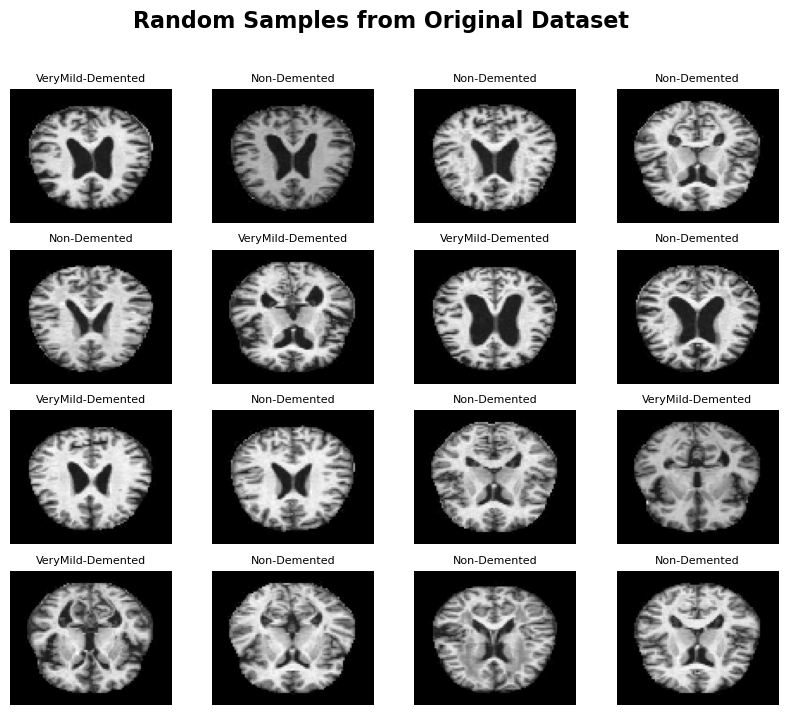

In [11]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Random Samples from Original Dataset", fontsize=16, fontweight='bold')

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X_train)-1 )
    plt.imshow(X_train[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y_train[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Random samples of generated dataset

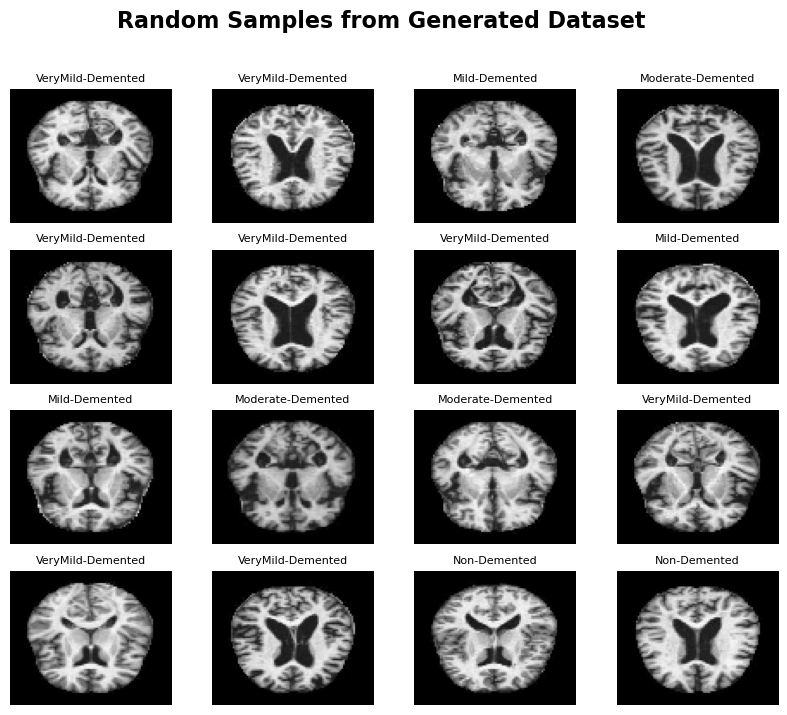

In [12]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Random Samples from Generated Dataset", fontsize=16, fontweight='bold')

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X_se_train) - 1 )
    plt.imshow(X_se_train[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y_se_train[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Train ResNet50, InceptionV3 & VGG19 Models With SMOTE-ENN

In [13]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

# ResNet50

In [14]:
# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base ResNet50 model
RN50_se_model = Sequential()

# Add the ResNet50 base model
RN50_se_model.add(base_model)

RN50_se_model.add(Dropout(0.10))

RN50_se_model.add(Flatten())

RN50_se_model.add(BatchNormalization())
RN50_se_model.add(Dense(612, activation='relu'))
RN50_se_model.add(Dropout(0.30))

RN50_se_model.add(Dense(356, activation='relu'))
RN50_se_model.add(Dropout(0.30))

RN50_se_model.add(Dense(4, activation='softmax'))

base_model.summary()

RN50_se_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 84, 100, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 39, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 39, 47, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [15]:
### Model Compilation
RN50_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [16]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

RN50_se_history = RN50_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
495/495 [==============================] - 39s 65ms/step - loss: 0.8432 - acc: 0.6554 - auc: 0.8863 - precision: 0.7118 - recall: 0.5883 - val_loss: 1.7974 - val_acc: 0.2382 - val_auc: 0.4685 - val_precision: 0.1922 - val_recall: 0.0794 - lr: 0.0100
Epoch 2/30
495/495 [==============================] - 32s 64ms/step - loss: 0.3401 - acc: 0.8575 - auc: 0.9785 - precision: 0.8675 - recall: 0.8449 - val_loss: 0.4725 - val_acc: 0.7638 - val_auc: 0.9578 - val_precision: 0.7693 - val_recall: 0.7471 - lr: 0.0100
Epoch 3/30
495/495 [==============================] - 32s 64ms/step - loss: 0.2032 - acc: 0.9227 - auc: 0.9915 - precision: 0.9292 - recall: 0.9175 - val_loss: 0.2400 - val_acc: 0.9029 - val_auc: 0.9895 - val_precision: 0.9056 - val_recall: 0.8978 - lr: 0.0100
Epoch 4/30
495/495 [==============================] - 31s 63ms/step - loss: 0.1090 - acc: 0.9616 - auc: 0.9972 - precision: 0.9631 - recall: 0.9602 - val_loss: 0.0855 - val_acc: 0.9691 - val_auc: 0.9986 - val_precisio

In [17]:
RN50_se_model.save('./ResNet50_SMOTEENN.h5')

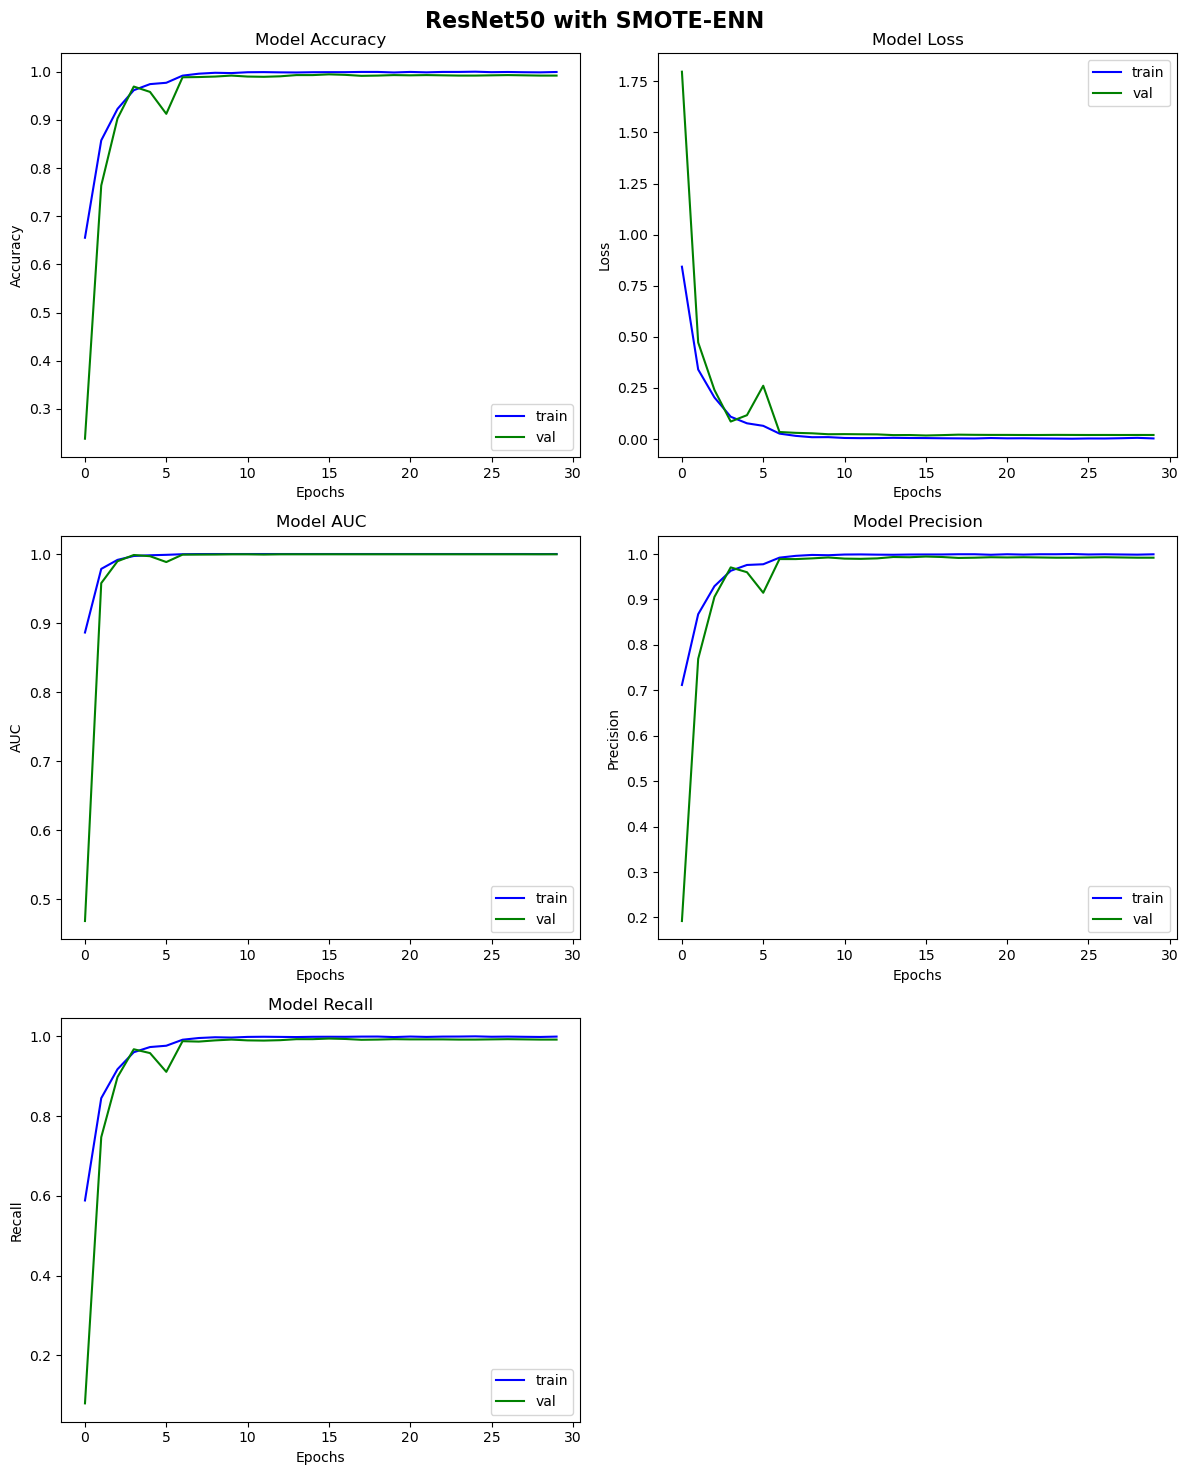

In [18]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("ResNet50 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(RN50_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(RN50_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(RN50_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(RN50_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(RN50_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(RN50_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(RN50_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(RN50_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(RN50_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(RN50_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# InceptionV3

In [19]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
IV3_se_model = Sequential()

# Add the VGG19 base model
IV3_se_model.add(base_model)

IV3_se_model.add(Dropout(0.10))

IV3_se_model.add(Flatten())

IV3_se_model.add(BatchNormalization())
IV3_se_model.add(Dense(612, activation='relu'))
IV3_se_model.add(Dropout(0.30))

IV3_se_model.add(Dense(356, activation='relu'))
IV3_se_model.add(Dropout(0.30))

IV3_se_model.add(Dense(4, activation='softmax'))

base_model.summary()

IV3_se_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 38, 46, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 38, 46, 32)  96          ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 38, 46, 32)   0           ['batch_normalization_

In [20]:
### Model Compilation
IV3_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [21]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

IV3_se_history = IV3_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
495/495 [==============================] - 36s 59ms/step - loss: 1.1628 - acc: 0.4960 - auc: 0.7735 - precision: 0.5955 - recall: 0.3542 - val_loss: 0.7442 - val_acc: 0.6717 - val_auc: 0.8959 - val_precision: 0.7627 - val_recall: 0.5154 - lr: 0.0100
Epoch 2/30
495/495 [==============================] - 28s 56ms/step - loss: 0.7063 - acc: 0.6686 - auc: 0.9064 - precision: 0.7378 - recall: 0.5723 - val_loss: 0.5712 - val_acc: 0.7324 - val_auc: 0.9386 - val_precision: 0.7817 - val_recall: 0.6576 - lr: 0.0100
Epoch 3/30
495/495 [==============================] - 28s 56ms/step - loss: 0.5586 - acc: 0.7463 - auc: 0.9420 - precision: 0.7793 - recall: 0.6994 - val_loss: 0.9030 - val_acc: 0.5852 - val_auc: 0.8564 - val_precision: 0.6097 - val_recall: 0.5382 - lr: 0.0100
Epoch 4/30
495/495 [==============================] - 28s 56ms/step - loss: 0.4625 - acc: 0.7971 - auc: 0.9606 - precision: 0.8200 - recall: 0.7684 - val_loss: 0.6706 - val_acc: 0.7319 - val_auc: 0.9230 - val_precisio

In [22]:
IV3_se_model.save('./InceptionV3_SMOTEENN.h5')

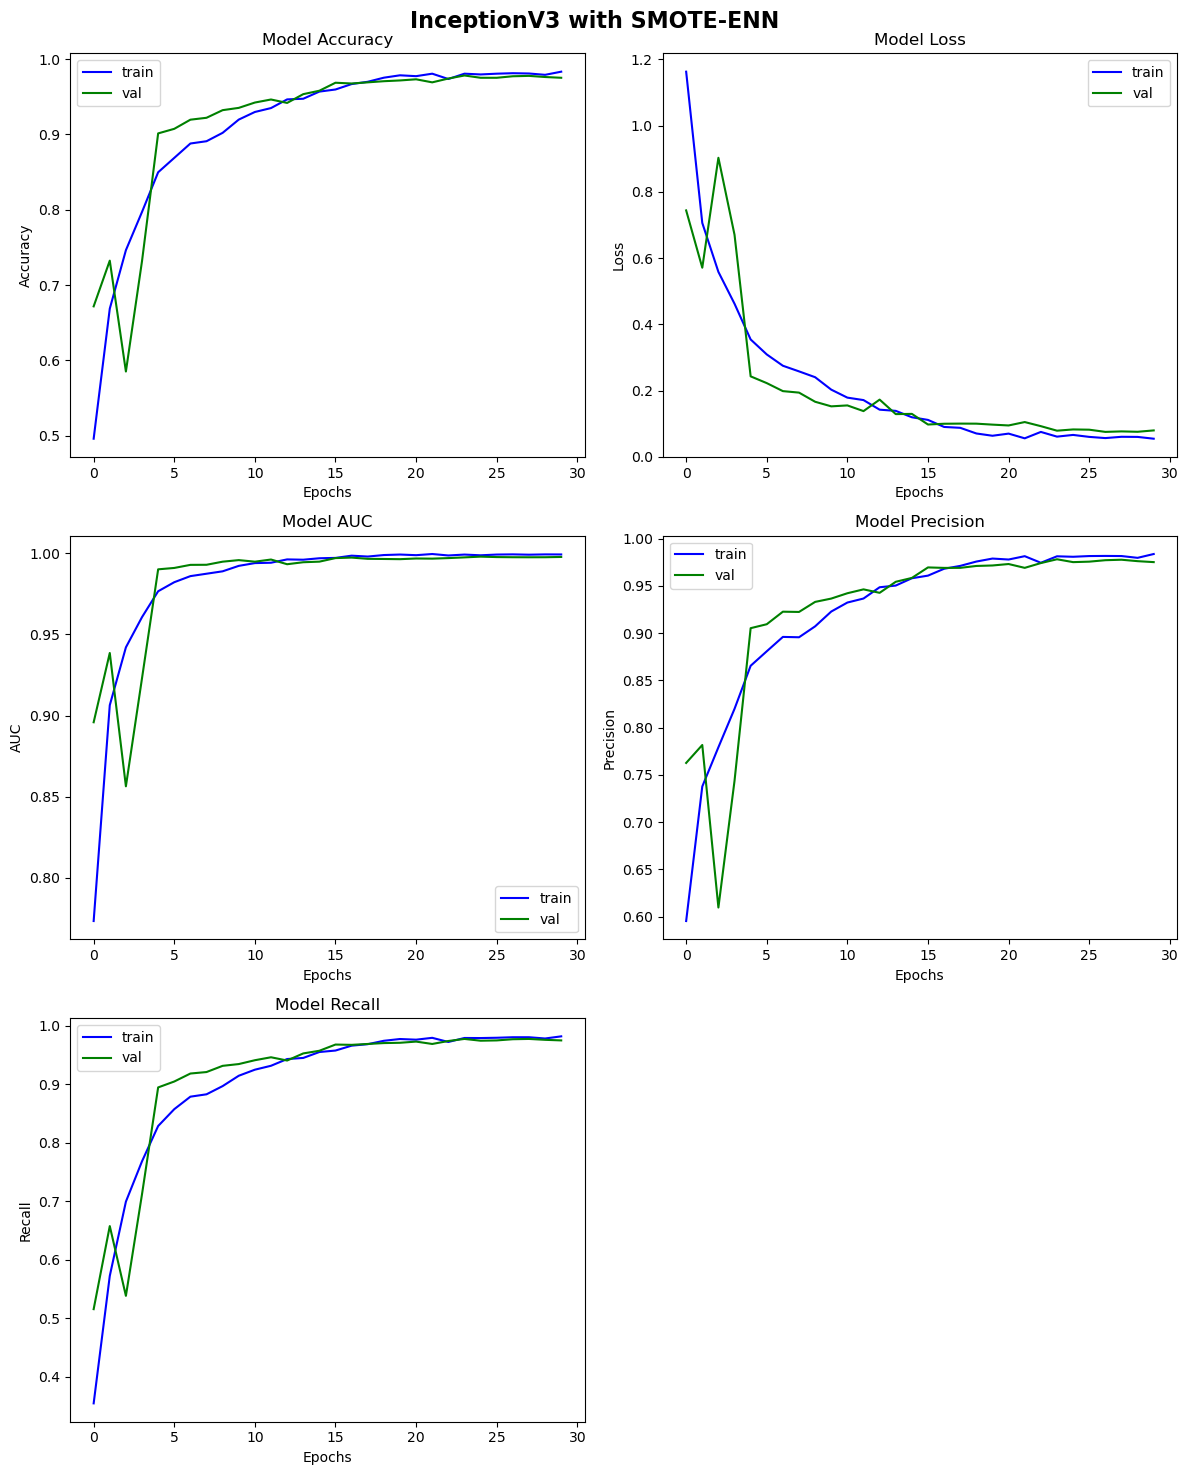

In [23]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("InceptionV3 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(IV3_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(IV3_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(IV3_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(IV3_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(IV3_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(IV3_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(IV3_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(IV3_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(IV3_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(IV3_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# VGG19

In [24]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
V19_se_model = Sequential()

# Add the VGG19 base model
V19_se_model.add(base_model)

V19_se_model.add(Dropout(0.10))

V19_se_model.add(Flatten())

V19_se_model.add(BatchNormalization())
V19_se_model.add(Dense(612, activation='relu'))
V19_se_model.add(Dropout(0.30))

V19_se_model.add(Dense(356, activation='relu'))
V19_se_model.add(Dropout(0.30))

V19_se_model.add(Dense(4, activation='softmax'))

base_model.summary()

V19_se_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 78, 94, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 78, 94, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 78, 94, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 39, 47, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 39, 47, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 39, 47, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 19, 23, 128)       0     

In [25]:
### Model Compilation
V19_se_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [26]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

V19_se_history = V19_se_model.fit(valAug.flow(X_se_train, y_se_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(X_se_val, y_se_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_se_train) / batch_size),
    validation_steps = math.ceil(len(X_se_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
495/495 [==============================] - 45s 83ms/step - loss: 1.0821 - acc: 0.4644 - auc: 0.7670 - precision: 0.7664 - recall: 0.2154 - val_loss: 1.1682 - val_acc: 0.5195 - val_auc: 0.7875 - val_precision: 0.5195 - val_recall: 0.5180 - lr: 0.0100
Epoch 2/30
495/495 [==============================] - 40s 80ms/step - loss: 0.7502 - acc: 0.6407 - auc: 0.8942 - precision: 0.7407 - recall: 0.4979 - val_loss: 0.8374 - val_acc: 0.6166 - val_auc: 0.8955 - val_precision: 0.6335 - val_recall: 0.6024 - lr: 0.0100
Epoch 3/30
495/495 [==============================] - 40s 80ms/step - loss: 0.5546 - acc: 0.7464 - auc: 0.9421 - precision: 0.7777 - recall: 0.6976 - val_loss: 3.5557 - val_acc: 0.5195 - val_auc: 0.7032 - val_precision: 0.5208 - val_recall: 0.5195 - lr: 0.0100
Epoch 4/30
495/495 [==============================] - 40s 80ms/step - loss: 0.4371 - acc: 0.8068 - auc: 0.9637 - precision: 0.8190 - recall: 0.7875 - val_loss: 0.6688 - val_acc: 0.7122 - val_auc: 0.9306 - val_precisio

In [27]:
V19_se_model.save('./VGG19_SMOTEENN.h5')

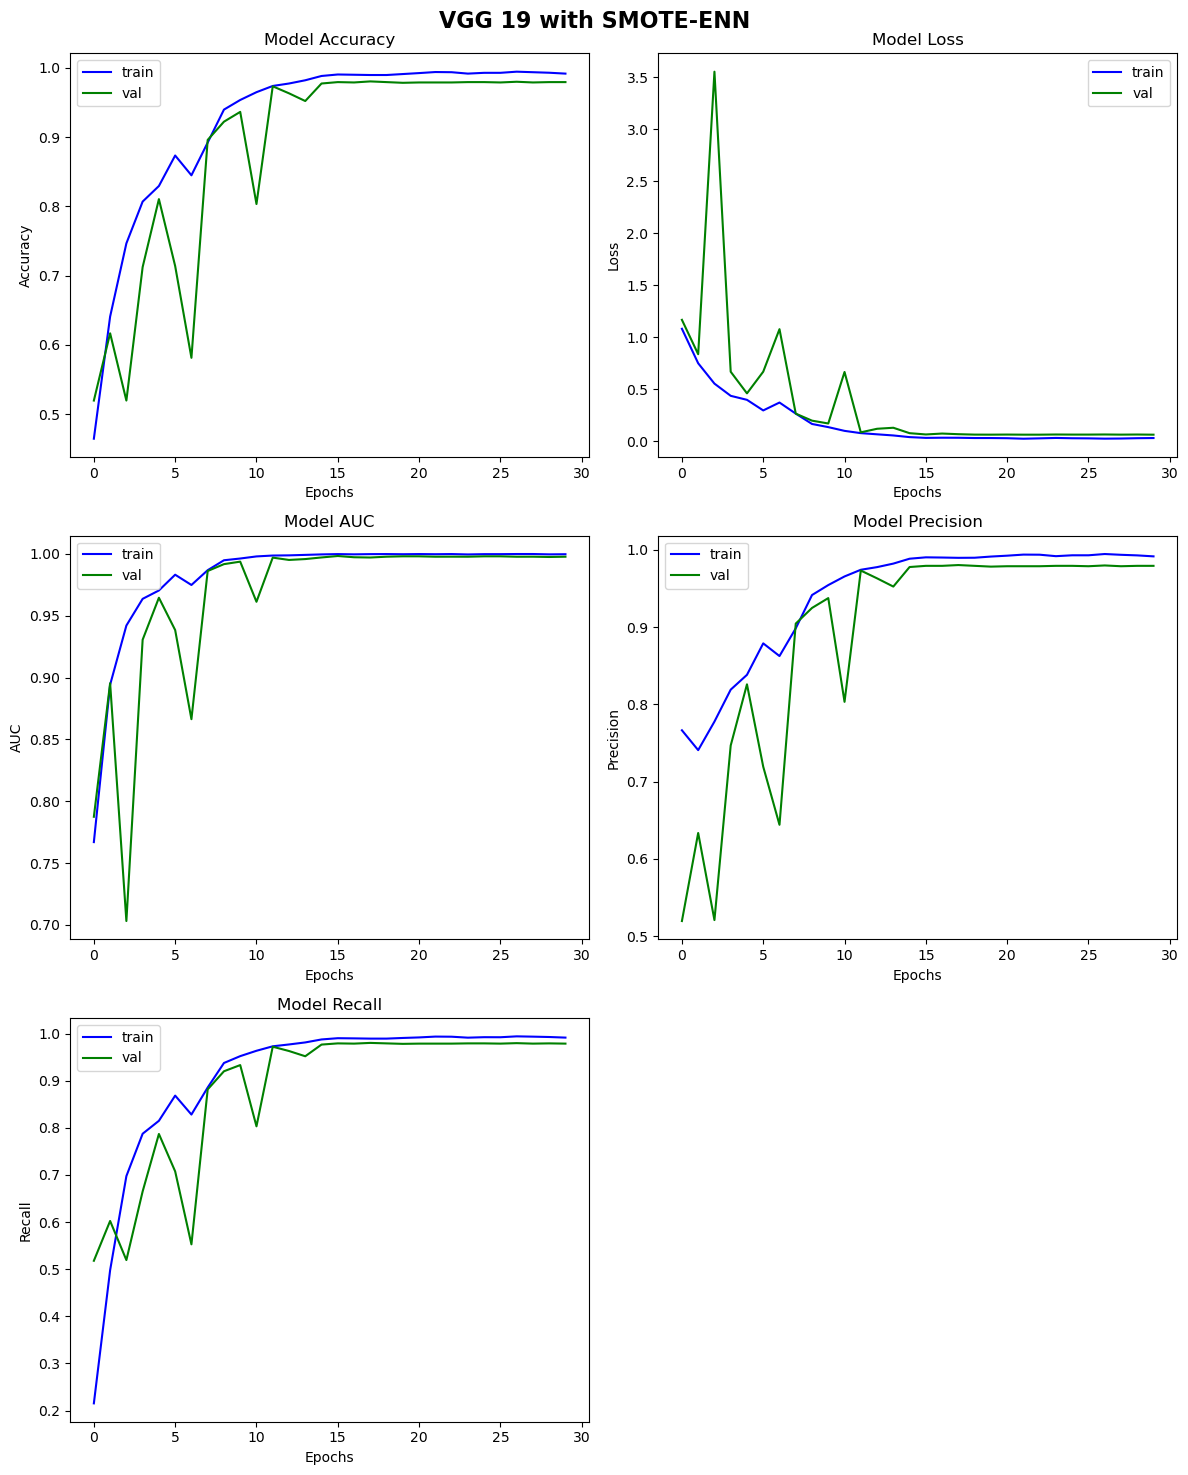

In [28]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("VGG 19 with SMOTE-ENN", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="train")
axes[0, 0].plot(V19_se_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="train")
axes[0, 1].plot(V19_se_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="train")
axes[1, 0].plot(V19_se_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="train")
axes[1, 1].plot(V19_se_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="train")
axes[2, 0].plot(V19_se_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# Train ResNet50, InceptionV3 & VGG19 Models Without SMOTE-ENN

# ResNet50

In [29]:
# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base ResNet50 model
RN50_model = Sequential()

# Add the ResNet50 base model
RN50_model.add(base_model)

RN50_model.add(Dropout(0.10))

RN50_model.add(Flatten())

RN50_model.add(BatchNormalization())
RN50_model.add(Dense(612, activation='relu'))
RN50_model.add(Dropout(0.30))

RN50_model.add(Dense(356, activation='relu'))
RN50_model.add(Dropout(0.30))

RN50_model.add(Dense(4, activation='softmax'))

base_model.summary()

RN50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 84, 100, 3)   0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 39, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 39, 47, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [30]:
### Model Compilation
RN50_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [31]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

RN50_history = RN50_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_train) / batch_size),
    validation_steps = math.ceil(len(x_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
257/257 [==============================] - 22s 67ms/step - loss: 1.2119 - acc: 0.4939 - auc: 0.7809 - precision: 0.5413 - recall: 0.3874 - val_loss: 1.2419 - val_acc: 0.3541 - val_auc: 0.6344 - val_precision: 0.4228 - val_recall: 0.1333 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 16s 63ms/step - loss: 0.9090 - acc: 0.5907 - auc: 0.8526 - precision: 0.6532 - recall: 0.4888 - val_loss: 1.1115 - val_acc: 0.5019 - val_auc: 0.8001 - val_precision: 0.5166 - val_recall: 0.4689 - lr: 0.0100
Epoch 3/30
257/257 [==============================] - 16s 64ms/step - loss: 0.6304 - acc: 0.7320 - auc: 0.9286 - precision: 0.7651 - recall: 0.6826 - val_loss: 1.3596 - val_acc: 0.3716 - val_auc: 0.7448 - val_precision: 0.3693 - val_recall: 0.3628 - lr: 0.0100
Epoch 4/30
257/257 [==============================] - 16s 64ms/step - loss: 0.3646 - acc: 0.8604 - auc: 0.9755 - precision: 0.8753 - recall: 0.8485 - val_loss: 0.5606 - val_acc: 0.7558 - val_auc: 0.9451 - val_precisio

In [32]:
RN50_model.save('./ResNet50.h5')

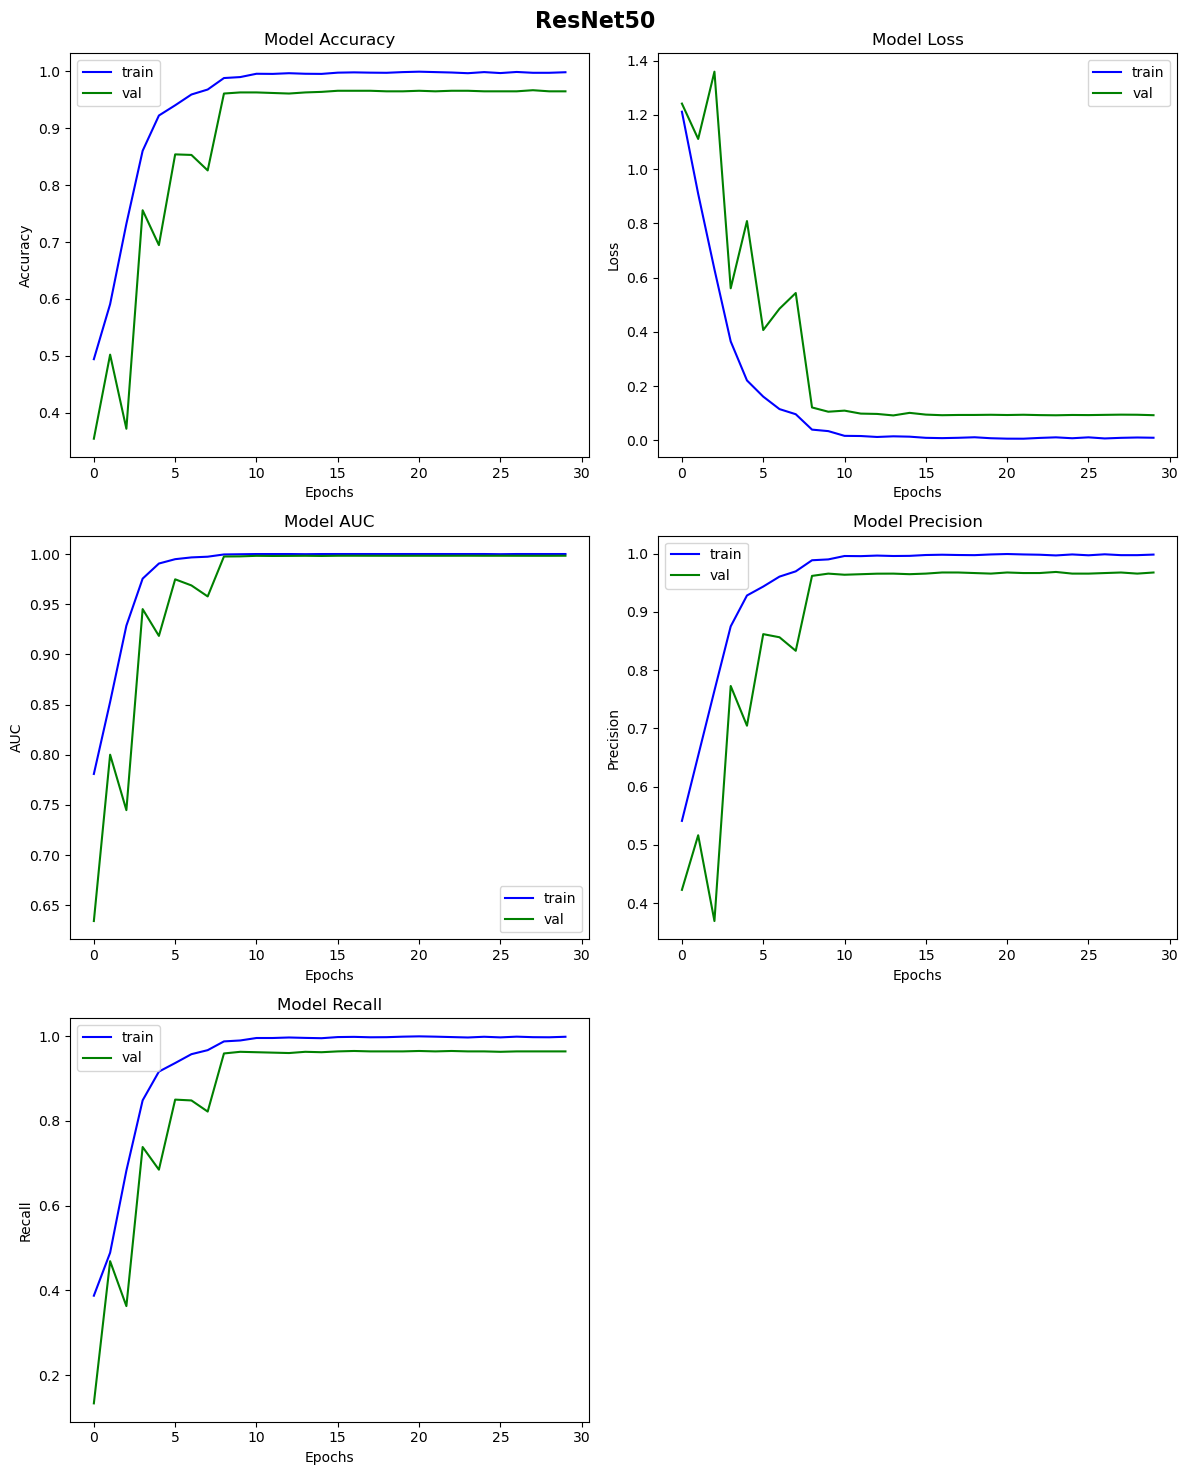

In [33]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("ResNet50", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(RN50_history.history['acc'], 'b', label="train")
axes[0, 0].plot(RN50_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(RN50_history.history['loss'], 'b', label="train")
axes[0, 1].plot(RN50_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(RN50_history.history['auc'], 'b', label="train")
axes[1, 0].plot(RN50_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(RN50_history.history['precision'], 'b', label="train")
axes[1, 1].plot(RN50_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(RN50_history.history['recall'], 'b', label="train")
axes[2, 0].plot(RN50_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# InceptionV3

In [34]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
IV3_model = Sequential()

# Add the VGG19 base model
IV3_model.add(base_model)

IV3_model.add(Dropout(0.10))

IV3_model.add(Flatten())

IV3_model.add(BatchNormalization())
IV3_model.add(Dense(612, activation='relu'))
IV3_model.add(Dropout(0.30))

IV3_model.add(Dense(356, activation='relu'))
IV3_model.add(Dropout(0.30))

IV3_model.add(Dense(4, activation='softmax'))

base_model.summary()

IV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 78, 94, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 38, 46, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_98 (BatchN  (None, 38, 46, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 38, 46, 32)   0           ['batch_normalization_

In [35]:
### Model Compilation
IV3_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [36]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

IV3_history = IV3_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_train) / batch_size),
    validation_steps = math.ceil(len(x_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
257/257 [==============================] - 21s 62ms/step - loss: 1.1822 - acc: 0.4698 - auc: 0.7693 - precision: 0.5223 - recall: 0.3361 - val_loss: 20.8626 - val_acc: 0.3385 - val_auc: 0.5666 - val_precision: 0.3245 - val_recall: 0.2607 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 14s 56ms/step - loss: 1.0288 - acc: 0.5180 - auc: 0.8088 - precision: 0.6019 - recall: 0.3784 - val_loss: 1.1166 - val_acc: 0.5370 - val_auc: 0.8271 - val_precision: 0.6391 - val_recall: 0.4066 - lr: 0.0100
Epoch 3/30
257/257 [==============================] - 14s 56ms/step - loss: 0.9550 - acc: 0.5496 - auc: 0.8314 - precision: 0.6396 - recall: 0.3979 - val_loss: 0.9119 - val_acc: 0.5700 - val_auc: 0.8449 - val_precision: 0.7155 - val_recall: 0.3375 - lr: 0.0100
Epoch 4/30
257/257 [==============================] - 14s 56ms/step - loss: 0.8942 - acc: 0.5820 - auc: 0.8513 - precision: 0.6665 - recall: 0.4151 - val_loss: 1.0420 - val_acc: 0.4669 - val_auc: 0.7903 - val_precisi

In [37]:
IV3_model.save('./InceptionV3.h5')

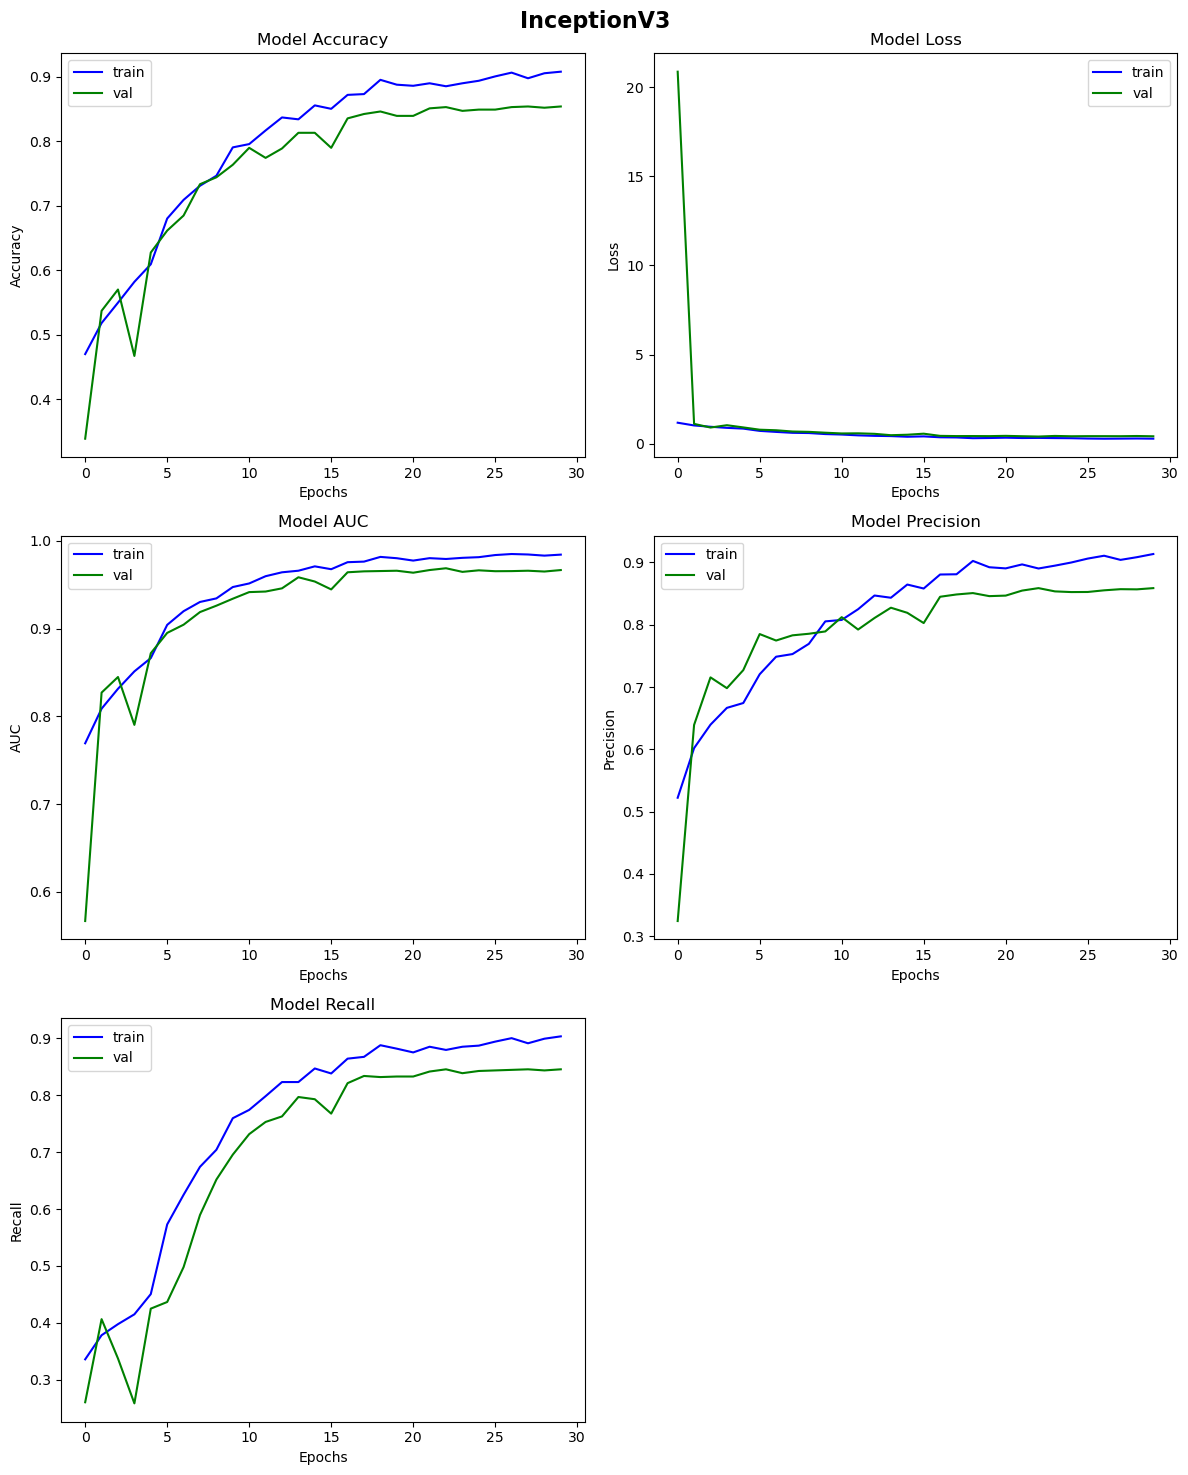

In [38]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("InceptionV3", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(IV3_history.history['acc'], 'b', label="train")
axes[0, 0].plot(IV3_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(IV3_history.history['loss'], 'b', label="train")
axes[0, 1].plot(IV3_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(IV3_history.history['auc'], 'b', label="train")
axes[1, 0].plot(IV3_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(IV3_history.history['precision'], 'b', label="train")
axes[1, 1].plot(IV3_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(IV3_history.history['recall'], 'b', label="train")
axes[2, 0].plot(IV3_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# VGG19

In [39]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size)

# Create a new model on top of the base VGG19 model
V19_model = Sequential()

# Add the VGG19 base model
V19_model.add(base_model)

V19_model.add(Dropout(0.10))

V19_model.add(Flatten())

V19_model.add(BatchNormalization())
V19_model.add(Dense(612, activation='relu'))
V19_model.add(Dropout(0.30))

V19_model.add(Dense(356, activation='relu'))
V19_model.add(Dropout(0.30))

V19_model.add(Dense(4, activation='softmax'))

base_model.summary()

V19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 78, 94, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 78, 94, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 78, 94, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 39, 47, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 39, 47, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 39, 47, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 19, 23, 128)       0     

In [40]:
### Model Compilation
V19_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [41]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 16

V19_history = V19_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
    validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
    steps_per_epoch = math.ceil(len(X_train) / batch_size),
    validation_steps = math.ceil(len(x_val) / batch_size),
    epochs= 30,
    batch_size=batch_size,
    callbacks = CALLBACKS
    )

Epoch 1/30
257/257 [==============================] - 23s 83ms/step - loss: 1.0208 - acc: 0.5173 - auc: 0.8042 - precision: 0.6341 - recall: 0.2870 - val_loss: 1.7680 - val_acc: 0.4990 - val_auc: 0.8125 - val_precision: 0.4990 - val_recall: 0.4990 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 21s 80ms/step - loss: 0.9230 - acc: 0.5632 - auc: 0.8386 - precision: 0.6813 - recall: 0.3816 - val_loss: 1.2720 - val_acc: 0.1887 - val_auc: 0.6212 - val_precision: 0.3333 - val_recall: 9.7276e-04 - lr: 0.0100
Epoch 3/30
257/257 [==============================] - 21s 80ms/step - loss: 0.8724 - acc: 0.5764 - auc: 0.8566 - precision: 0.6836 - recall: 0.4098 - val_loss: 0.8814 - val_acc: 0.6070 - val_auc: 0.8652 - val_precision: 0.6119 - val_recall: 0.5982 - lr: 0.0100
Epoch 4/30
257/257 [==============================] - 21s 81ms/step - loss: 0.8625 - acc: 0.5956 - auc: 0.8608 - precision: 0.6701 - recall: 0.4421 - val_loss: 2.1312 - val_acc: 0.1391 - val_auc: 0.5578 - val_prec

In [42]:
V19_model.save('./VGG19.h5')

In [43]:
del X_train, y_train, X_se_train, y_se_train , x_val, y_val, X_se_val ,y_se_val #no more needed

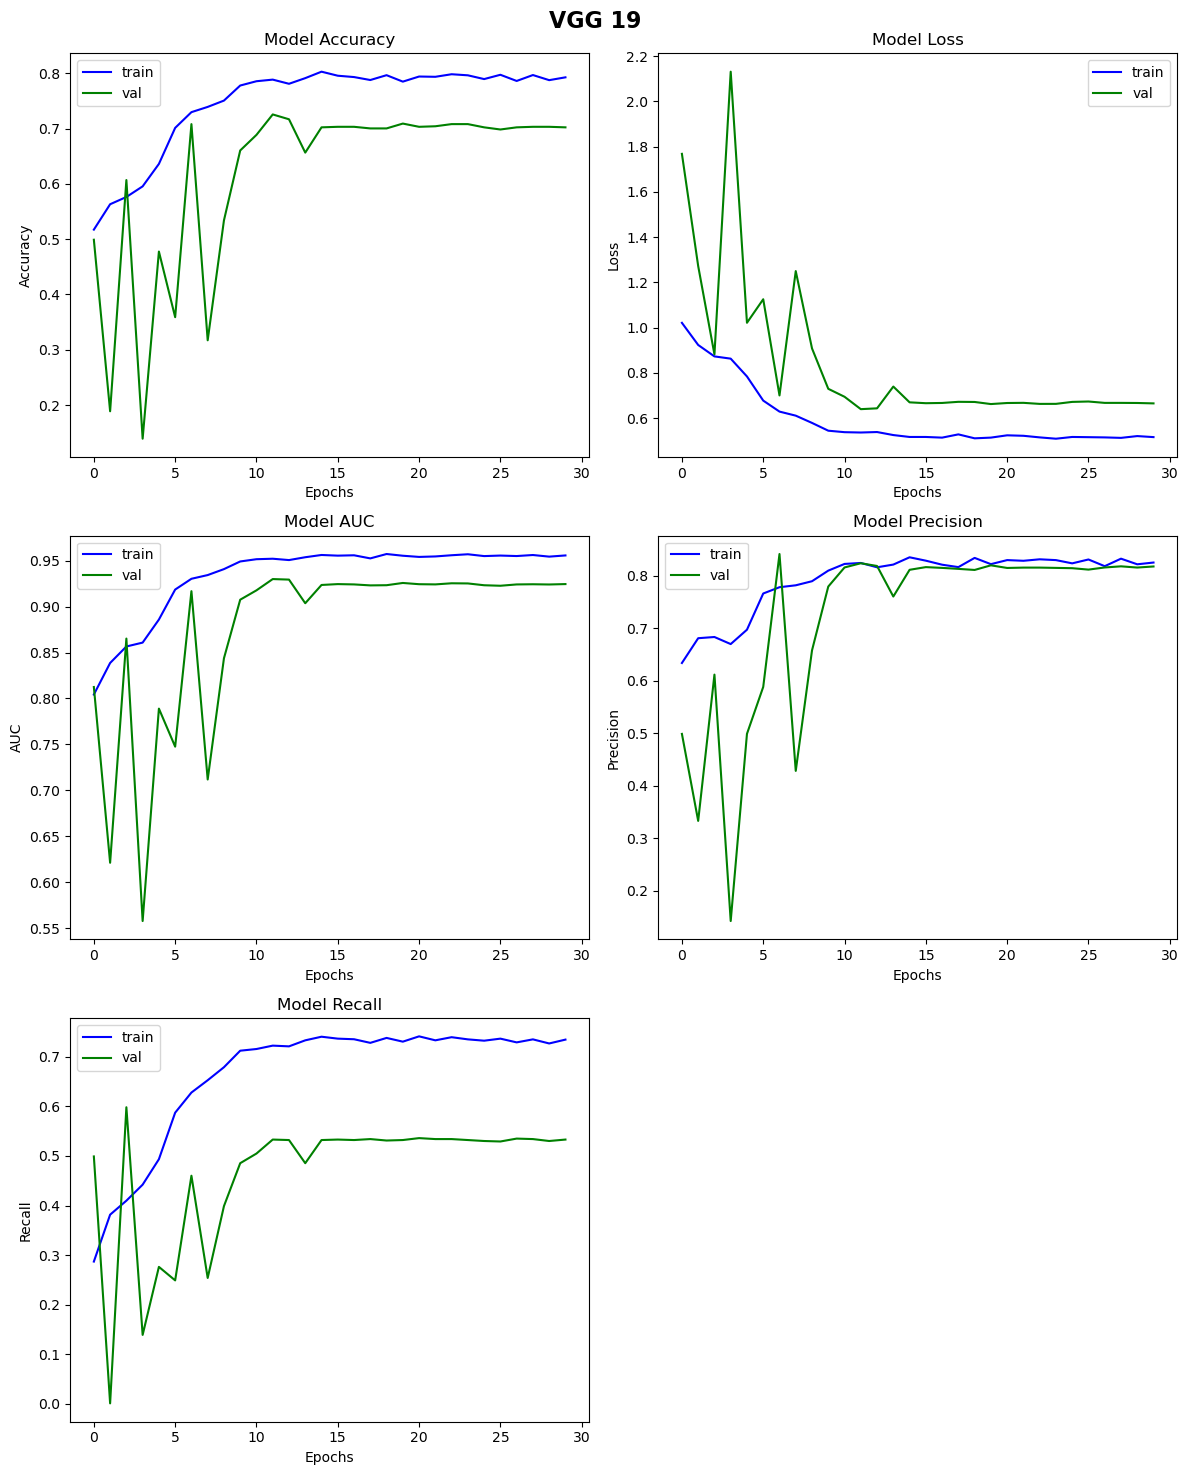

In [44]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("VGG 19", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(V19_history.history['acc'], 'b', label="train")
axes[0, 0].plot(V19_history.history['val_acc'], 'g', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(V19_history.history['loss'], 'b', label="train")
axes[0, 1].plot(V19_history.history['val_loss'], 'g', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(V19_history.history['auc'], 'b', label="train")
axes[1, 0].plot(V19_history.history['val_auc'], 'g', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(V19_history.history['precision'], 'b', label="train")
axes[1, 1].plot(V19_history.history['val_precision'], 'g', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(V19_history.history['recall'], 'b', label="train")
axes[2, 0].plot(V19_history.history['val_recall'], 'g', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()

# Model Evaluation

# Models Training Perfomance Comparision

# All Models

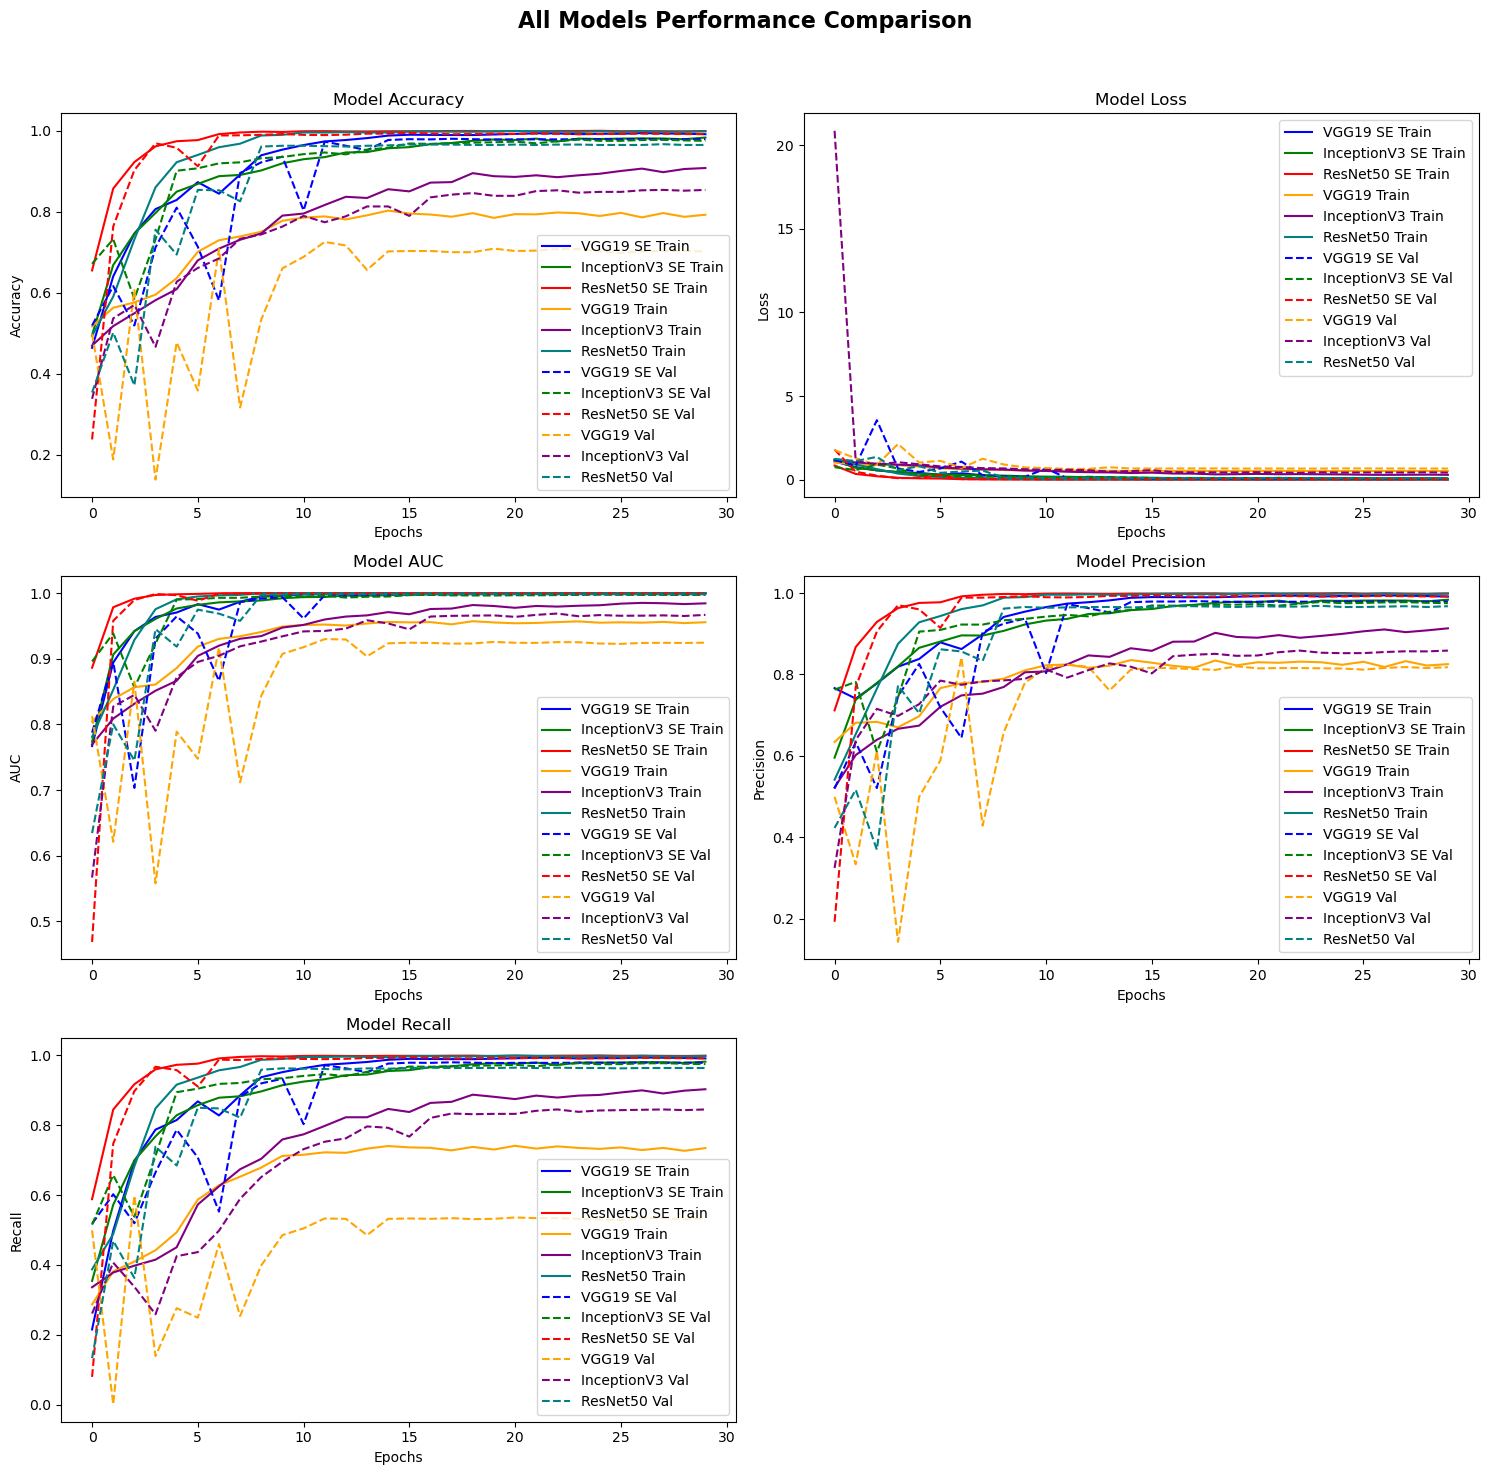

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
fig.suptitle("All Models Performance Comparison", fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="VGG19 SE Train")
axes[0, 0].plot(IV3_se_history.history['acc'], 'g', label="InceptionV3 SE Train")
axes[0, 0].plot(RN50_se_history.history['acc'], 'r', label="ResNet50 SE Train")
axes[0, 0].plot(V19_history.history['acc'], color='orange', label="VGG19 Train")
axes[0, 0].plot(IV3_history.history['acc'], color='purple', label="InceptionV3 Train")
axes[0, 0].plot(RN50_history.history['acc'], color='teal', label="ResNet50 Train")
axes[0, 0].plot(V19_se_history.history['val_acc'], linestyle='--', color='b', label="VGG19 SE Val")
axes[0, 0].plot(IV3_se_history.history['val_acc'], linestyle='--', color='g', label="InceptionV3 SE Val")
axes[0, 0].plot(RN50_se_history.history['val_acc'], linestyle='--', color='r', label="ResNet50 SE Val")
axes[0, 0].plot(V19_history.history['val_acc'], linestyle='--', color='orange', label="VGG19 Val")
axes[0, 0].plot(IV3_history.history['val_acc'], linestyle='--', color='purple', label="InceptionV3 Val")
axes[0, 0].plot(RN50_history.history['val_acc'], linestyle='--', color='teal', label="ResNet50 Val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Loss Plot
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="VGG19 SE Train")
axes[0, 1].plot(IV3_se_history.history['loss'], 'g', label="InceptionV3 SE Train")
axes[0, 1].plot(RN50_se_history.history['loss'], 'r', label="ResNet50 SE Train")
axes[0, 1].plot(V19_history.history['loss'], color='orange', label="VGG19 Train")
axes[0, 1].plot(IV3_history.history['loss'], color='purple', label="InceptionV3 Train")
axes[0, 1].plot(RN50_history.history['loss'], color='teal', label="ResNet50 Train")
axes[0, 1].plot(V19_se_history.history['val_loss'], linestyle='--', color='b', label="VGG19 SE Val")
axes[0, 1].plot(IV3_se_history.history['val_loss'], linestyle='--', color='g', label="InceptionV3 SE Val")
axes[0, 1].plot(RN50_se_history.history['val_loss'], linestyle='--', color='r', label="ResNet50 SE Val")
axes[0, 1].plot(V19_history.history['val_loss'], linestyle='--', color='orange', label="VGG19 Val")
axes[0, 1].plot(IV3_history.history['val_loss'], linestyle='--', color='purple', label="InceptionV3 Val")
axes[0, 1].plot(RN50_history.history['val_loss'], linestyle='--', color='teal', label="ResNet50 Val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# AUC Plot
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="VGG19 SE Train")
axes[1, 0].plot(IV3_se_history.history['auc'], 'g', label="InceptionV3 SE Train")
axes[1, 0].plot(RN50_se_history.history['auc'], 'r', label="ResNet50 SE Train")
axes[1, 0].plot(V19_history.history['auc'], color='orange', label="VGG19 Train")
axes[1, 0].plot(IV3_history.history['auc'], color='purple', label="InceptionV3 Train")
axes[1, 0].plot(RN50_history.history['auc'], color='teal', label="ResNet50 Train")
axes[1, 0].plot(V19_se_history.history['val_auc'], linestyle='--', color='b', label="VGG19 SE Val")
axes[1, 0].plot(IV3_se_history.history['val_auc'], linestyle='--', color='g', label="InceptionV3 SE Val")
axes[1, 0].plot(RN50_se_history.history['val_auc'], linestyle='--', color='r', label="ResNet50 SE Val")
axes[1, 0].plot(V19_history.history['val_auc'], linestyle='--', color='orange', label="VGG19 Val")
axes[1, 0].plot(IV3_history.history['val_auc'], linestyle='--', color='purple', label="InceptionV3 Val")
axes[1, 0].plot(RN50_history.history['val_auc'], linestyle='--', color='teal', label="ResNet50 Val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Precision Plot
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="VGG19 SE Train")
axes[1, 1].plot(IV3_se_history.history['precision'], 'g', label="InceptionV3 SE Train")
axes[1, 1].plot(RN50_se_history.history['precision'], 'r', label="ResNet50 SE Train")
axes[1, 1].plot(V19_history.history['precision'], color='orange', label="VGG19 Train")
axes[1, 1].plot(IV3_history.history['precision'], color='purple', label="InceptionV3 Train")
axes[1, 1].plot(RN50_history.history['precision'], color='teal', label="ResNet50 Train")
axes[1, 1].plot(V19_se_history.history['val_precision'], linestyle='--', color='b', label="VGG19 SE Val")
axes[1, 1].plot(IV3_se_history.history['val_precision'], linestyle='--', color='g', label="InceptionV3 SE Val")
axes[1, 1].plot(RN50_se_history.history['val_precision'], linestyle='--', color='r', label="ResNet50 SE Val")
axes[1, 1].plot(V19_history.history['val_precision'], linestyle='--', color='orange', label="VGG19 Val")
axes[1, 1].plot(IV3_history.history['val_precision'], linestyle='--', color='purple', label="InceptionV3 Val")
axes[1, 1].plot(RN50_history.history['val_precision'], linestyle='--', color='teal', label="ResNet50 Val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Recall Plot
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="VGG19 SE Train")
axes[2, 0].plot(IV3_se_history.history['recall'], 'g', label="InceptionV3 SE Train")
axes[2, 0].plot(RN50_se_history.history['recall'], 'r', label="ResNet50 SE Train")
axes[2, 0].plot(V19_history.history['recall'], color='orange', label="VGG19 Train")
axes[2, 0].plot(IV3_history.history['recall'], color='purple', label="InceptionV3 Train")
axes[2, 0].plot(RN50_history.history['recall'], color='teal', label="ResNet50 Train")
axes[2, 0].plot(V19_se_history.history['val_recall'], linestyle='--', color='b', label="VGG19 SE Val")
axes[2, 0].plot(IV3_se_history.history['val_recall'], linestyle='--', color='g', label="InceptionV3 SE Val")
axes[2, 0].plot(RN50_se_history.history['val_recall'], linestyle='--', color='r', label="ResNet50 SE Val")
axes[2, 0].plot(V19_history.history['val_recall'], linestyle='--', color='orange', label="VGG19 Val")
axes[2, 0].plot(IV3_history.history['val_recall'], linestyle='--', color='purple', label="InceptionV3 Val")
axes[2, 0].plot(RN50_history.history['val_recall'], linestyle='--', color='teal', label="ResNet50 Val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove the empty subplot (bottom right corner)
fig.delaxes(axes[2, 1])

# Adjust layout to make sure plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


# Models trained with SMOTE-ENN

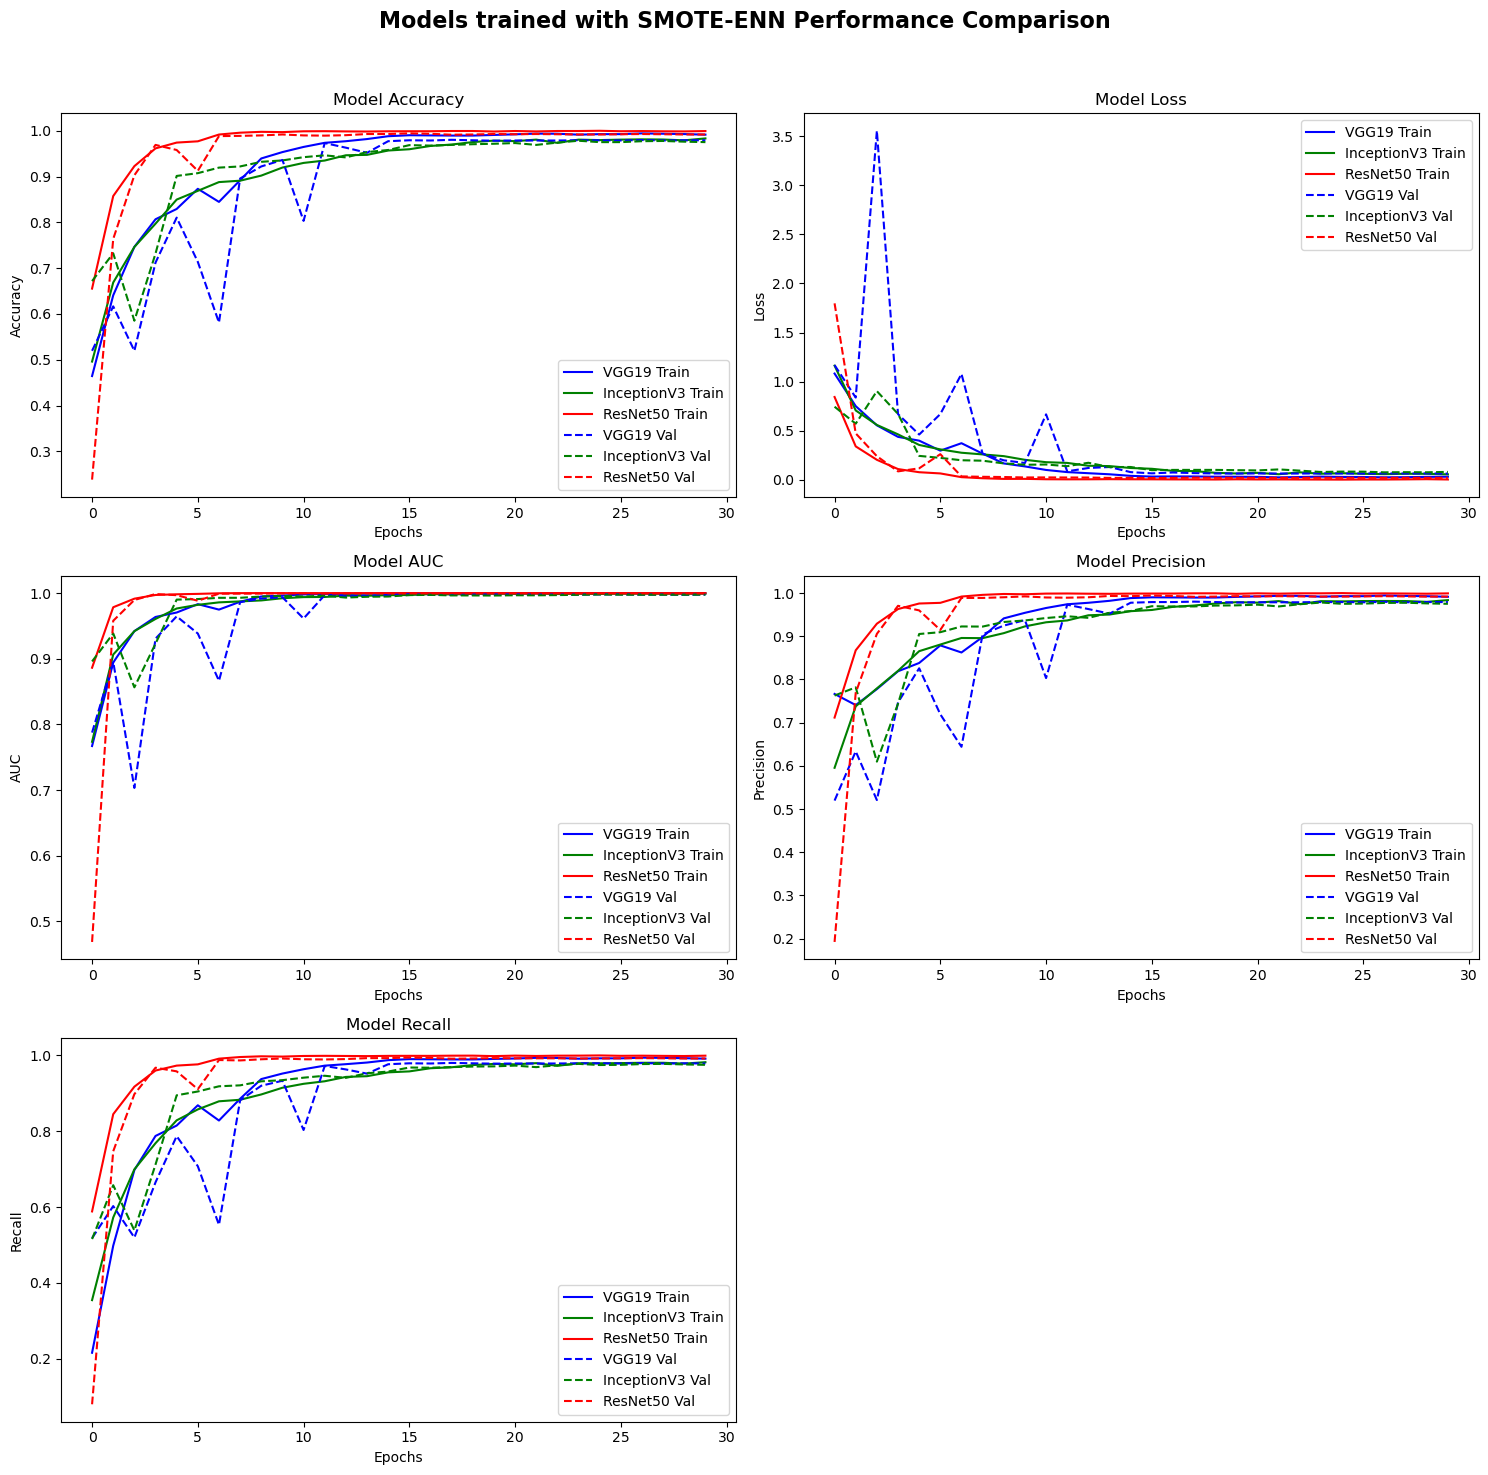

In [46]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
fig.suptitle("Models trained with SMOTE-ENN Performance Comparison", fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="VGG19 Train")
axes[0, 0].plot(IV3_se_history.history['acc'], 'g', label="InceptionV3 Train")
axes[0, 0].plot(RN50_se_history.history['acc'], 'r', label="ResNet50 Train")
axes[0, 0].plot(V19_se_history.history['val_acc'], 'b--', label="VGG19 Val")
axes[0, 0].plot(IV3_se_history.history['val_acc'], 'g--', label="InceptionV3 Val")
axes[0, 0].plot(RN50_se_history.history['val_acc'], 'r--', label="ResNet50 Val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Loss Plot
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="VGG19 Train")
axes[0, 1].plot(IV3_se_history.history['loss'], 'g', label="InceptionV3 Train")
axes[0, 1].plot(RN50_se_history.history['loss'], 'r', label="ResNet50 Train")
axes[0, 1].plot(V19_se_history.history['val_loss'], 'b--', label="VGG19 Val")
axes[0, 1].plot(IV3_se_history.history['val_loss'], 'g--', label="InceptionV3 Val")
axes[0, 1].plot(RN50_se_history.history['val_loss'], 'r--', label="ResNet50 Val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# AUC Plot
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="VGG19 Train")
axes[1, 0].plot(IV3_se_history.history['auc'], 'g', label="InceptionV3 Train")
axes[1, 0].plot(RN50_se_history.history['auc'], 'r', label="ResNet50 Train")
axes[1, 0].plot(V19_se_history.history['val_auc'], 'b--', label="VGG19 Val")
axes[1, 0].plot(IV3_se_history.history['val_auc'], 'g--', label="InceptionV3 Val")
axes[1, 0].plot(RN50_se_history.history['val_auc'], 'r--', label="ResNet50 Val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Precision Plot
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="VGG19 Train")
axes[1, 1].plot(IV3_se_history.history['precision'], 'g', label="InceptionV3 Train")
axes[1, 1].plot(RN50_se_history.history['precision'], 'r', label="ResNet50 Train")
axes[1, 1].plot(V19_se_history.history['val_precision'], 'b--', label="VGG19 Val")
axes[1, 1].plot(IV3_se_history.history['val_precision'], 'g--', label="InceptionV3 Val")
axes[1, 1].plot(RN50_se_history.history['val_precision'], 'r--', label="ResNet50 Val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Recall Plot
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="VGG19 Train")
axes[2, 0].plot(IV3_se_history.history['recall'], 'g', label="InceptionV3 Train")
axes[2, 0].plot(RN50_se_history.history['recall'], 'r', label="ResNet50 Train")
axes[2, 0].plot(V19_se_history.history['val_recall'], 'b--', label="VGG19 Val")
axes[2, 0].plot(IV3_se_history.history['val_recall'], 'g--', label="InceptionV3 Val")
axes[2, 0].plot(RN50_se_history.history['val_recall'], 'r--', label="ResNet50 Val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove the empty subplot (bottom right corner)
fig.delaxes(axes[2, 1])

# Adjust layout to make sure plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


# Models trained without SMOTE-ENN

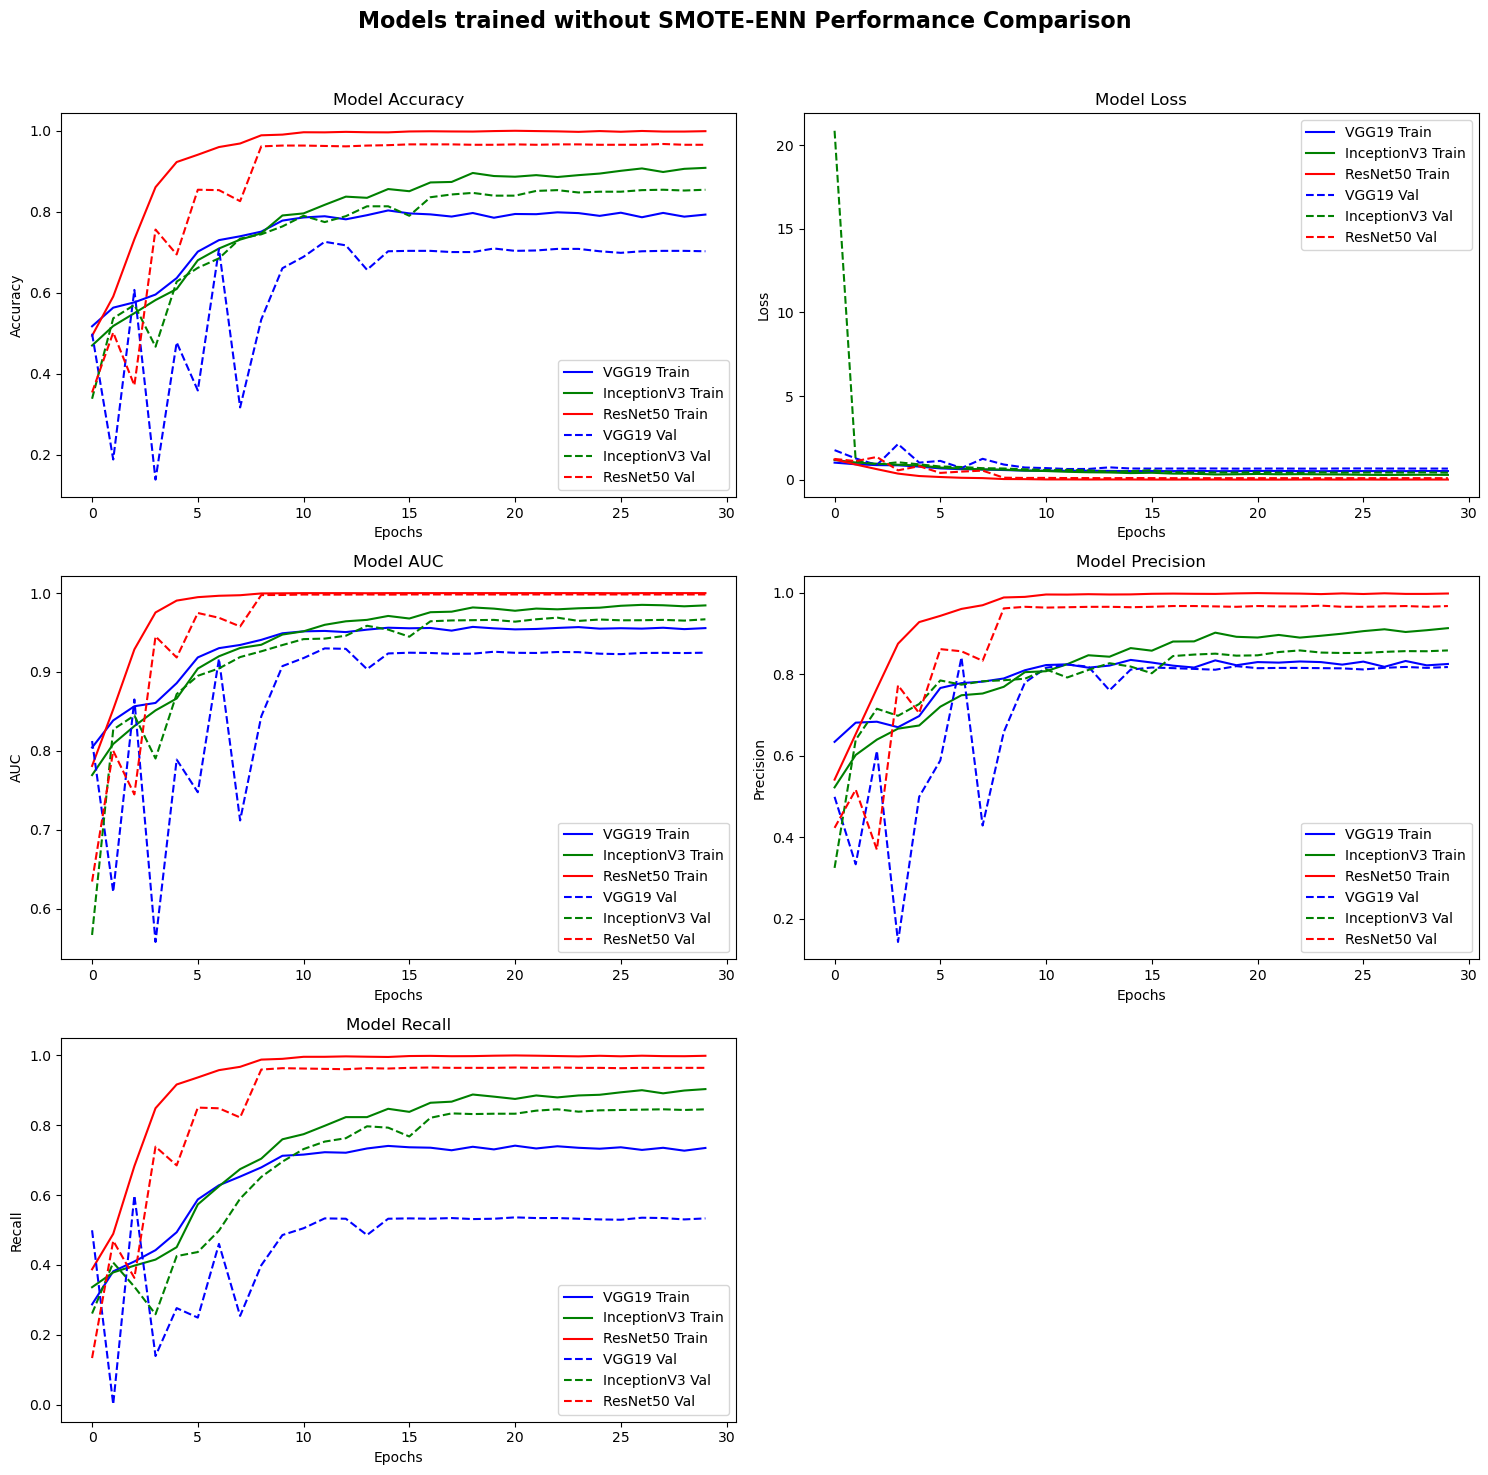

In [47]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
fig.suptitle("Models trained without SMOTE-ENN Performance Comparison", fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(V19_history.history['acc'], 'b', label="VGG19 Train")
axes[0, 0].plot(IV3_history.history['acc'], 'g', label="InceptionV3 Train")
axes[0, 0].plot(RN50_history.history['acc'], 'r', label="ResNet50 Train")
axes[0, 0].plot(V19_history.history['val_acc'], 'b--', label="VGG19 Val")
axes[0, 0].plot(IV3_history.history['val_acc'], 'g--', label="InceptionV3 Val")
axes[0, 0].plot(RN50_history.history['val_acc'], 'r--', label="ResNet50 Val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Loss Plot
axes[0, 1].plot(V19_history.history['loss'], 'b', label="VGG19 Train")
axes[0, 1].plot(IV3_history.history['loss'], 'g', label="InceptionV3 Train")
axes[0, 1].plot(RN50_history.history['loss'], 'r', label="ResNet50 Train")
axes[0, 1].plot(V19_history.history['val_loss'], 'b--', label="VGG19 Val")
axes[0, 1].plot(IV3_history.history['val_loss'], 'g--', label="InceptionV3 Val")
axes[0, 1].plot(RN50_history.history['val_loss'], 'r--', label="ResNet50 Val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# AUC Plot
axes[1, 0].plot(V19_history.history['auc'], 'b', label="VGG19 Train")
axes[1, 0].plot(IV3_history.history['auc'], 'g', label="InceptionV3 Train")
axes[1, 0].plot(RN50_history.history['auc'], 'r', label="ResNet50 Train")
axes[1, 0].plot(V19_history.history['val_auc'], 'b--', label="VGG19 Val")
axes[1, 0].plot(IV3_history.history['val_auc'], 'g--', label="InceptionV3 Val")
axes[1, 0].plot(RN50_history.history['val_auc'], 'r--', label="ResNet50 Val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Precision Plot
axes[1, 1].plot(V19_history.history['precision'], 'b', label="VGG19 Train")
axes[1, 1].plot(IV3_history.history['precision'], 'g', label="InceptionV3 Train")
axes[1, 1].plot(RN50_history.history['precision'], 'r', label="ResNet50 Train")
axes[1, 1].plot(V19_history.history['val_precision'], 'b--', label="VGG19 Val")
axes[1, 1].plot(IV3_history.history['val_precision'], 'g--', label="InceptionV3 Val")
axes[1, 1].plot(RN50_history.history['val_precision'], 'r--', label="ResNet50 Val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Recall Plot
axes[2, 0].plot(V19_history.history['recall'], 'b', label="VGG19 Train")
axes[2, 0].plot(IV3_history.history['recall'], 'g', label="InceptionV3 Train")
axes[2, 0].plot(RN50_history.history['recall'], 'r', label="ResNet50 Train")
axes[2, 0].plot(V19_history.history['val_recall'], 'b--', label="VGG19 Val")
axes[2, 0].plot(IV3_history.history['val_recall'], 'g--', label="InceptionV3 Val")
axes[2, 0].plot(RN50_history.history['val_recall'], 'r--', label="ResNet50 Val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove the empty subplot (bottom right corner)
fig.delaxes(axes[2, 1])

# Adjust layout to make sure plots don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


# Comparision Based on Model

# ResNet50 trained with and without SMOTE-ENN Performance Comparision 

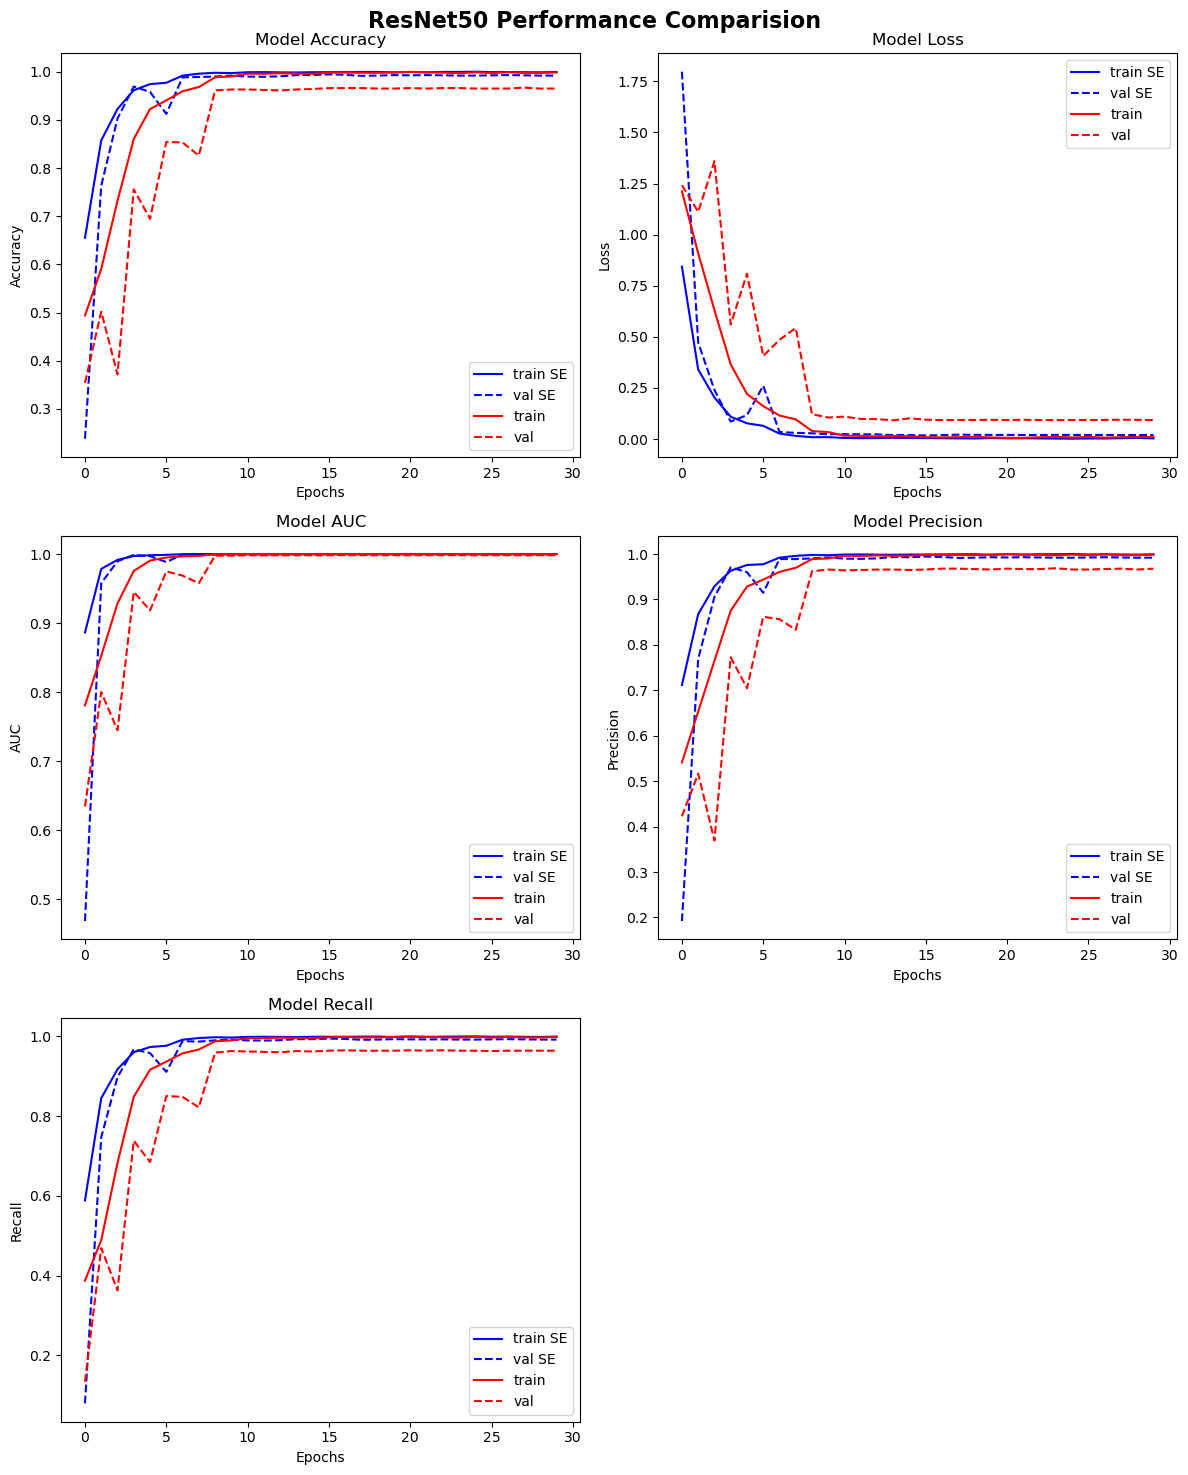

In [48]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("ResNet50 Performance Comparision", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(RN50_se_history.history['acc'], 'b', label="train SE")
axes[0, 0].plot(RN50_se_history.history['val_acc'], 'b--', label="val SE")
axes[0, 0].plot(RN50_history.history['acc'], 'r', label="train")
axes[0, 0].plot(RN50_history.history['val_acc'], 'r--', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(RN50_se_history.history['loss'], 'b', label="train SE")
axes[0, 1].plot(RN50_se_history.history['val_loss'], 'b--', label="val SE")
axes[0, 1].plot(RN50_history.history['loss'], 'r', label="train")
axes[0, 1].plot(RN50_history.history['val_loss'], 'r--', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(RN50_se_history.history['auc'], 'b', label="train SE")
axes[1, 0].plot(RN50_se_history.history['val_auc'], 'b--', label="val SE")
axes[1, 0].plot(RN50_history.history['auc'], 'r', label="train")
axes[1, 0].plot(RN50_history.history['val_auc'], 'r--', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(RN50_se_history.history['precision'], 'b', label="train SE")
axes[1, 1].plot(RN50_se_history.history['val_precision'], 'b--', label="val SE")
axes[1, 1].plot(RN50_history.history['precision'], 'r', label="train")
axes[1, 1].plot(RN50_history.history['val_precision'], 'r--', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(RN50_se_history.history['recall'], 'b', label="train SE")
axes[2, 0].plot(RN50_se_history.history['val_recall'], 'b--', label="val SE")
axes[2, 0].plot(RN50_history.history['recall'], 'r', label="train")
axes[2, 0].plot(RN50_history.history['val_recall'], 'r--', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# InceptionV3 trained with and without SMOTE-ENN Performance Comparision 

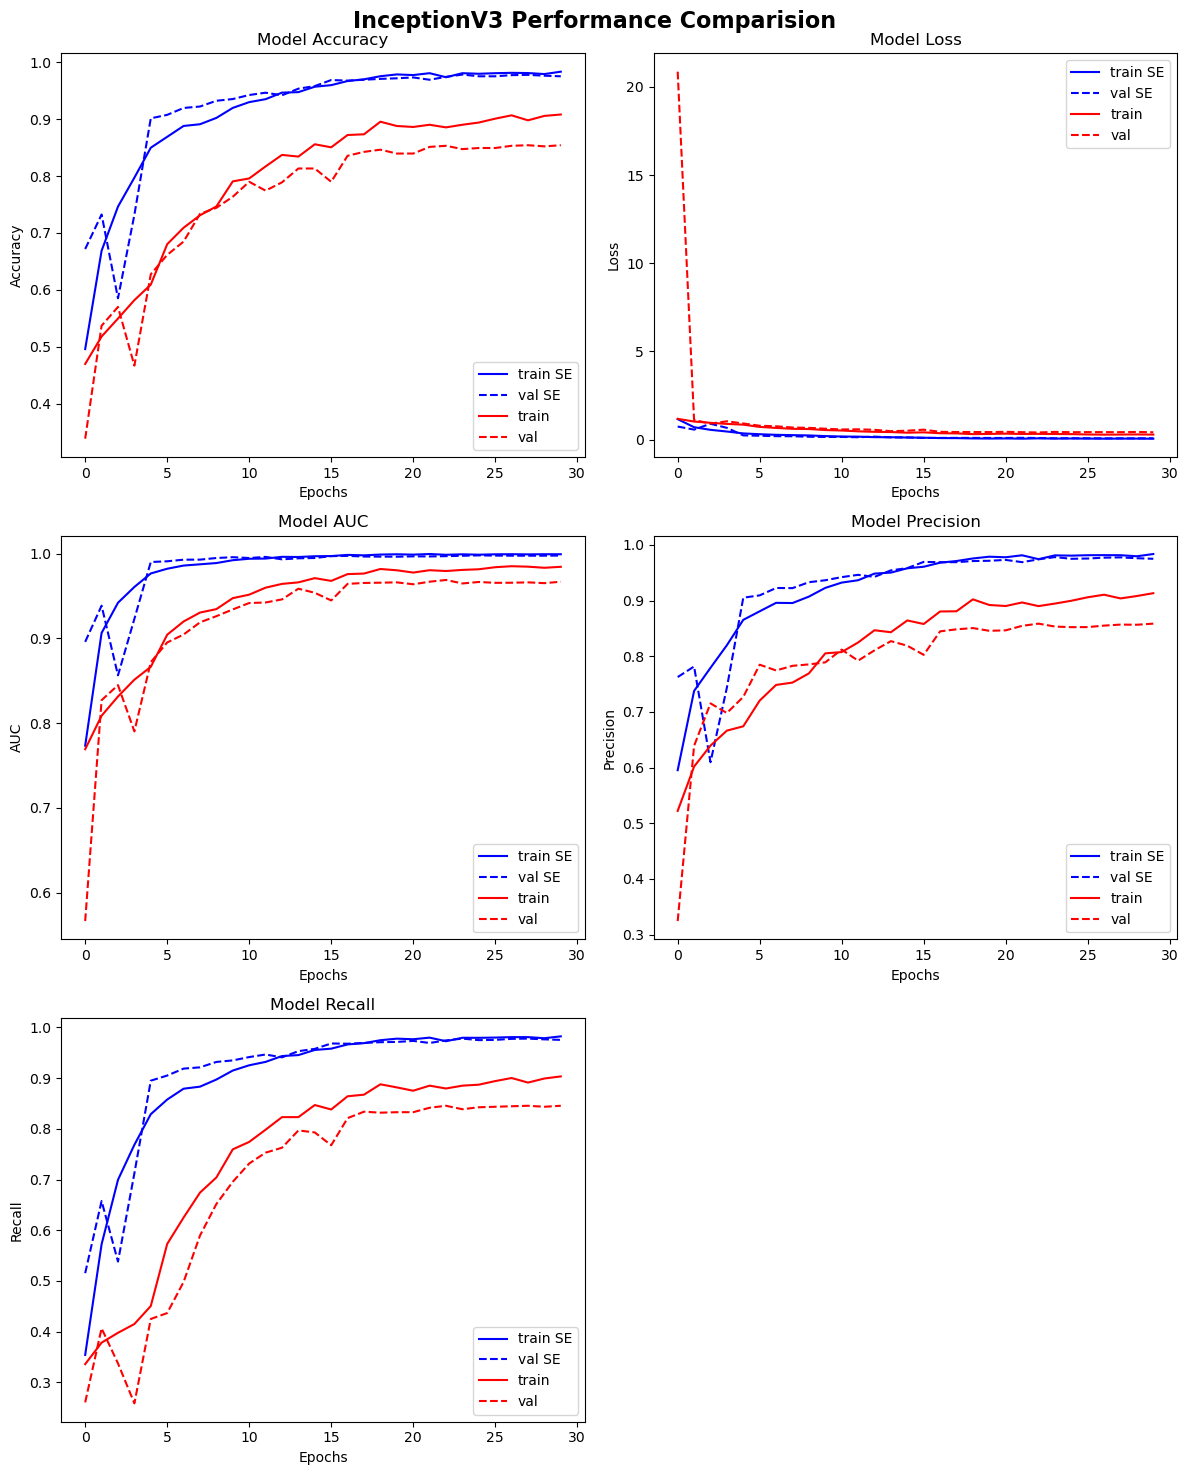

In [49]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("InceptionV3 Performance Comparision", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(IV3_se_history.history['acc'], 'b', label="train SE")
axes[0, 0].plot(IV3_se_history.history['val_acc'], 'b--', label="val SE")
axes[0, 0].plot(IV3_history.history['acc'], 'r', label="train")
axes[0, 0].plot(IV3_history.history['val_acc'], 'r--', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(IV3_se_history.history['loss'], 'b', label="train SE")
axes[0, 1].plot(IV3_se_history.history['val_loss'], 'b--', label="val SE")
axes[0, 1].plot(IV3_history.history['loss'], 'r', label="train")
axes[0, 1].plot(IV3_history.history['val_loss'], 'r--', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(IV3_se_history.history['auc'], 'b', label="train SE")
axes[1, 0].plot(IV3_se_history.history['val_auc'], 'b--', label="val SE")
axes[1, 0].plot(IV3_history.history['auc'], 'r', label="train")
axes[1, 0].plot(IV3_history.history['val_auc'], 'r--', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(IV3_se_history.history['precision'], 'b', label="train SE")
axes[1, 1].plot(IV3_se_history.history['val_precision'], 'b--', label="val SE")
axes[1, 1].plot(IV3_history.history['precision'], 'r', label="train")
axes[1, 1].plot(IV3_history.history['val_precision'], 'r--', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(IV3_se_history.history['recall'], 'b', label="train SE")
axes[2, 0].plot(IV3_se_history.history['val_recall'], 'b--', label="val SE")
axes[2, 0].plot(IV3_history.history['recall'], 'r', label="train")
axes[2, 0].plot(IV3_history.history['val_recall'], 'r--', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


# VGG19 trained with and without SMOTE-ENN Performance Comparision 

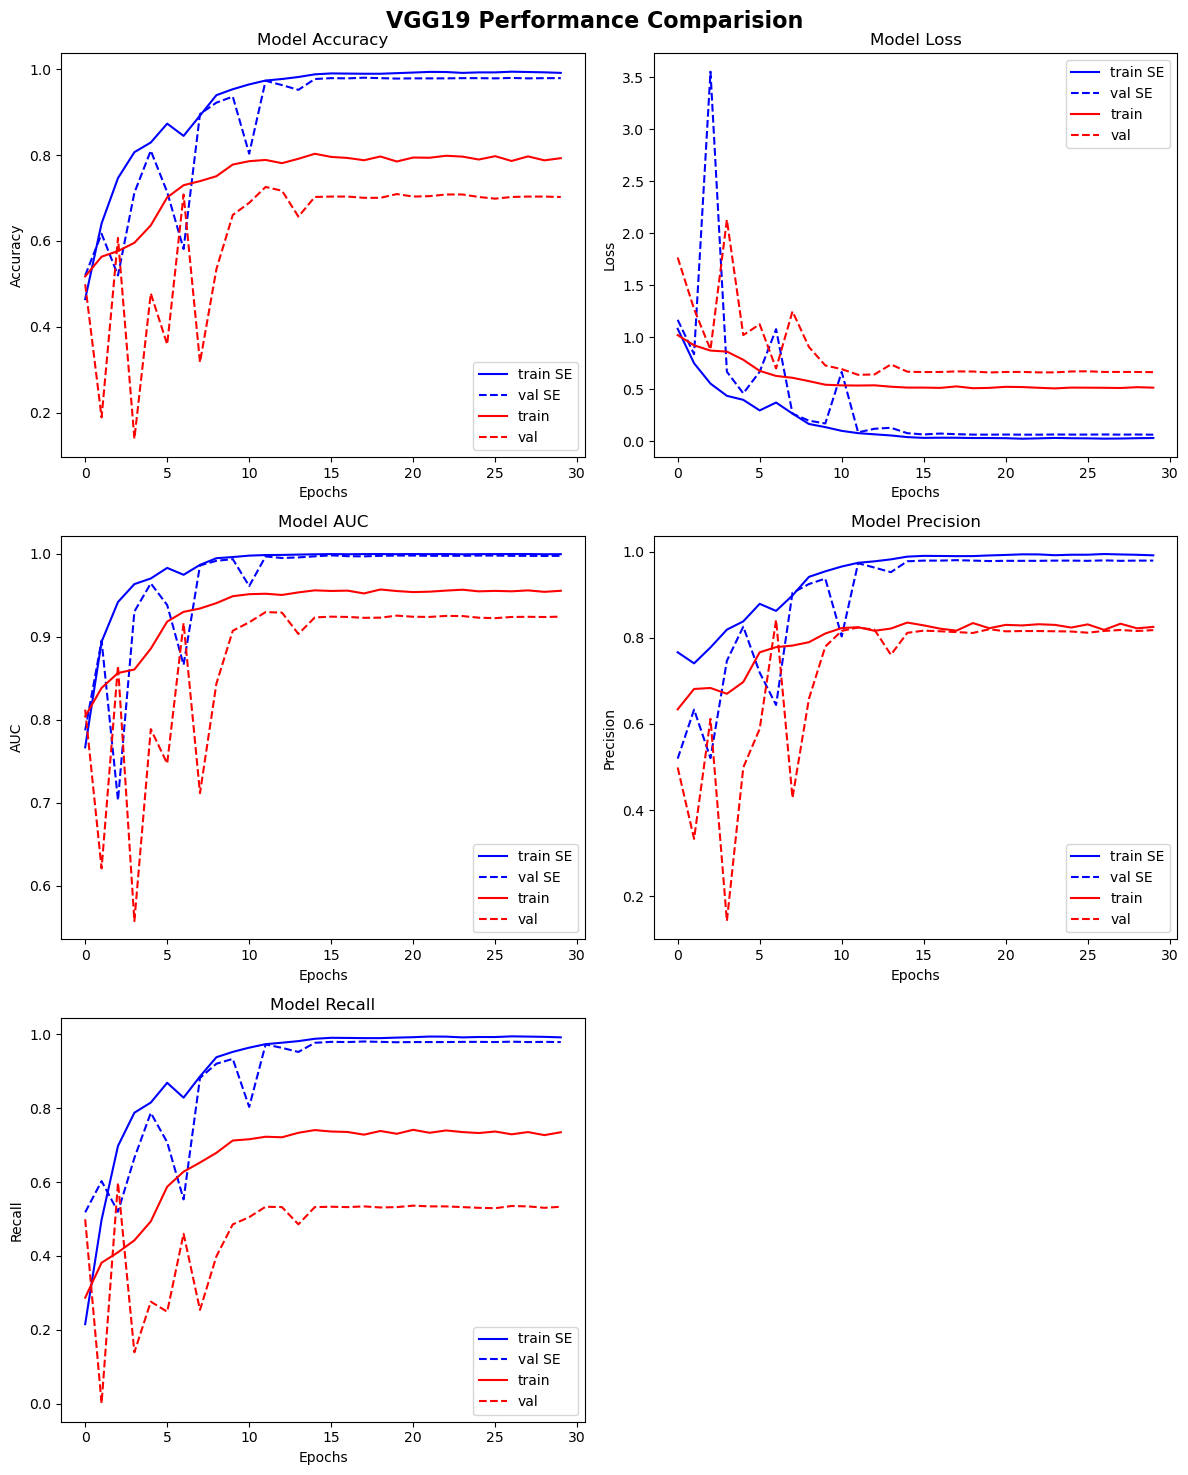

In [50]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle("VGG19 Performance Comparision", fontsize=16, fontweight='bold')

# Plot Accuracy
axes[0, 0].plot(V19_se_history.history['acc'], 'b', label="train SE")
axes[0, 0].plot(V19_se_history.history['val_acc'], 'b--', label="val SE")
axes[0, 0].plot(V19_history.history['acc'], 'r', label="train")
axes[0, 0].plot(V19_history.history['val_acc'], 'r--', label="val")
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(V19_se_history.history['loss'], 'b', label="train SE")
axes[0, 1].plot(V19_se_history.history['val_loss'], 'b--', label="val SE")
axes[0, 1].plot(V19_history.history['loss'], 'r', label="train")
axes[0, 1].plot(V19_history.history['val_loss'], 'r--', label="val")
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot AUC
axes[1, 0].plot(V19_se_history.history['auc'], 'b', label="train SE")
axes[1, 0].plot(V19_se_history.history['val_auc'], 'b--', label="val SE")
axes[1, 0].plot(V19_history.history['auc'], 'r', label="train")
axes[1, 0].plot(V19_history.history['val_auc'], 'r--', label="val")
axes[1, 0].set_title("Model AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision
axes[1, 1].plot(V19_se_history.history['precision'], 'b', label="train SE")
axes[1, 1].plot(V19_se_history.history['val_precision'], 'b--', label="val SE")
axes[1, 1].plot(V19_history.history['precision'], 'r', label="train")
axes[1, 1].plot(V19_history.history['val_precision'], 'r--', label="val")
axes[1, 1].set_title("Model Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall
axes[2, 0].plot(V19_se_history.history['recall'], 'b', label="train SE")
axes[2, 0].plot(V19_se_history.history['val_recall'], 'b--', label="val SE")
axes[2, 0].plot(V19_history.history['recall'], 'r', label="train")
axes[2, 0].plot(V19_history.history['val_recall'], 'r--', label="val")
axes[2, 0].set_title("Model Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Remove empty subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


In [51]:
del V19_history,RN50_history,IV3_se_history,IV3_history,V19_se_history,RN50_se_history #no more needed

# Model Evaluation

In [52]:
# ResNet50 with Smote-Enn
test_scores = RN50_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("ResNet50 with Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# ResNet without Smote-Enn
test_scores = RN50_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("ResNet50 without Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# InceptionV3 with Smote-Enn
test_scores = IV3_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("InceptionV3 with Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# InceptionV3 without Smote-Enn
test_scores = IV3_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("InceptionV3 without Smote-Enn:")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# VGG19 with Smote-Enn
test_scores = V19_se_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("VGG19 with Smote-Enn")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

# VGG19 without Smote-Enn
test_scores = V19_model.evaluate(x_test, y_test, batch_size = 2)
precision = test_scores[3]
recall = test_scores[4]
f1_score = 2 * (precision * recall) / (precision + recall)
print("VGG19 without Smote-Enn")
print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))

643/643 [==============================] - 9s 12ms/step - loss: 0.2363 - acc: 0.9487 - auc: 0.9857 - precision: 0.9486 - recall: 0.9479
ResNet50 with Smote-Enn:
Testing Accuracy: 	 94.867808 %
Testing AC: 		 98.567575 %
Testing Precision: 	 94.863814 %
Testing Recall: 	 94.790047 %
Testing F1-Score: 	 94.826916 %
643/643 [==============================] - 9s 14ms/step - loss: 0.1007 - acc: 0.9689 - auc: 0.9967 - precision: 0.9711 - recall: 0.9681
ResNet50 without Smote-Enn:
Testing Accuracy: 	 96.889579 %
Testing AC: 		 99.673665 %
Testing Precision: 	 97.113883 %
Testing Recall: 	 96.811819 %
Testing F1-Score: 	 96.962616 %
643/643 [==============================] - 12s 16ms/step - loss: 0.2937 - acc: 0.9012 - auc: 0.9838 - precision: 0.9019 - recall: 0.9012
InceptionV3 with Smote-Enn:
Testing Accuracy: 	 90.124416 %
Testing AC: 		 98.377919 %
Testing Precision: 	 90.194553 %
Testing Recall: 	 90.124416 %
Testing F1-Score: 	 90.159471 %
643/643 [==============================] - 11s 1

In [53]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# ResNet50 with Smote-Enn
RN50_se_pred_labels = RN50_se_model.predict(x_test, batch_size=2)
RN50_se_rounded_pred_labels = [roundoff(labels) for labels in RN50_se_pred_labels]
print("ResNet50 with Smote-Enn:")
print(classification_report(y_test, RN50_se_rounded_pred_labels, target_names=CLASSES))

# ResNet without Smote-Enn
RN50_pred_labels = RN50_model.predict(x_test, batch_size=2)
RN50_rounded_pred_labels = [roundoff(labels) for labels in RN50_pred_labels]
print("ResNet without Smote-Enn:")
print(classification_report(y_test, RN50_rounded_pred_labels, target_names=CLASSES))

# InceptionV3 with Smote-Enn
IV3_se_pred_labels = IV3_se_model.predict(x_test, batch_size=2)
IV3_se_rounded_pred_labels = [roundoff(labels) for labels in IV3_se_pred_labels]
print("InceptionV3 with Smote-Enn:")
print(classification_report(y_test, IV3_se_rounded_pred_labels, target_names=CLASSES))

# InceptionV3 without Smote-Enn
IV3_pred_labels = IV3_model.predict(x_test, batch_size=2)
IV3_rounded_pred_labels = [roundoff(labels) for labels in IV3_pred_labels]
print("InceptionV3 without Smote-Enn:")
print(classification_report(y_test, IV3_rounded_pred_labels, target_names=CLASSES))

# VGG19 with Smote-Enn
V19_se_pred_labels = V19_se_model.predict(x_test, batch_size=2)
V19_se_rounded_pred_labels = [roundoff(labels) for labels in V19_se_pred_labels]
print("VGG19 with Smote-Enn:")
print(classification_report(y_test, V19_se_rounded_pred_labels, target_names=CLASSES))

# VGG19 without Smote-Enn
V19_pred_labels = V19_model.predict(x_test, batch_size=2)
V19_rounded_pred_labels = [roundoff(labels) for labels in V19_pred_labels]
print("VGG19 without Smote-Enn:")
print(classification_report(y_test, V19_rounded_pred_labels, target_names=CLASSES))

643/643 [==============================] - 7s 10ms/step
ResNet50 with Smote-Enn:
                   precision    recall  f1-score   support

    Mild-Demented       0.98      0.98      0.98       179
Moderate-Demented       1.00      1.00      1.00        15
     Non-Demented       0.97      0.93      0.95       636
VeryMild-Demented       0.91      0.96      0.93       456

        micro avg       0.95      0.95      0.95      1286
        macro avg       0.96      0.97      0.97      1286
     weighted avg       0.95      0.95      0.95      1286
      samples avg       0.95      0.95      0.95      1286

643/643 [==============================] - 7s 10ms/step
ResNet without Smote-Enn:
                   precision    recall  f1-score   support

    Mild-Demented       0.96      0.92      0.94       179
Moderate-Demented       0.94      1.00      0.97        15
     Non-Demented       0.98      0.98      0.98       636
VeryMild-Demented       0.95      0.98      0.96       456

      

c:\Users\mayan\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


643/643 [==============================] - 5s 8ms/step
VGG19 with Smote-Enn:
                   precision    recall  f1-score   support

    Mild-Demented       0.94      0.95      0.95       179
Moderate-Demented       1.00      1.00      1.00        15
     Non-Demented       0.96      0.88      0.92       636
VeryMild-Demented       0.84      0.94      0.89       456

        micro avg       0.91      0.91      0.91      1286
        macro avg       0.94      0.94      0.94      1286
     weighted avg       0.92      0.91      0.92      1286
      samples avg       0.91      0.91      0.91      1286

643/643 [==============================] - 5s 8ms/step
VGG19 without Smote-Enn:
                   precision    recall  f1-score   support

    Mild-Demented       0.40      0.84      0.54       179
Moderate-Demented       0.00      0.00      0.00        15
     Non-Demented       0.92      0.86      0.88       636
VeryMild-Demented       0.68      0.46      0.55       456

        micr

c:\Users\mayan\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\mayan\AppData\Local\Temp\ipykernel_17060\2482147582.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Leave space for the suptitle


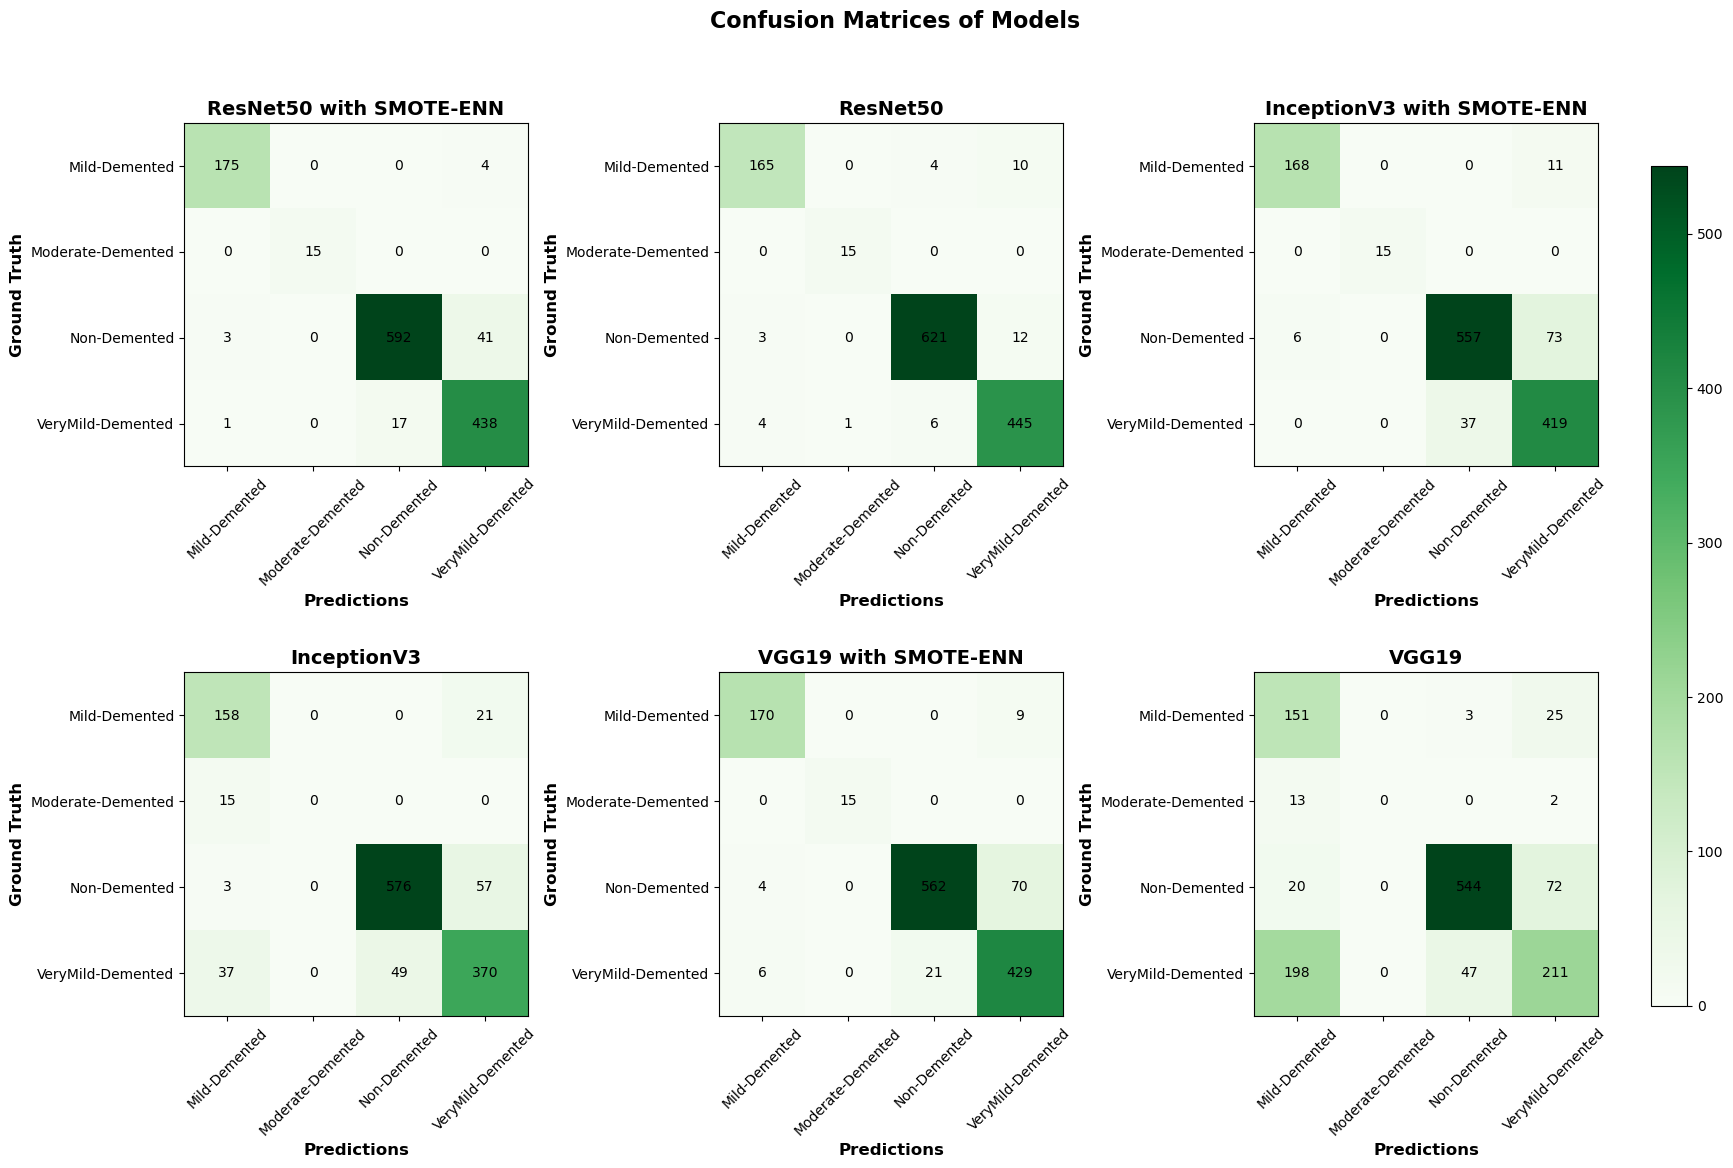

In [54]:
RN50_se_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(RN50_se_pred_labels, axis=1))
RN50_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(RN50_pred_labels, axis=1))
IV3_se_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(IV3_se_pred_labels, axis=1))
IV3_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(IV3_pred_labels, axis=1))
V19_se_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(V19_se_pred_labels, axis=1))
V19_conf_arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(V19_pred_labels, axis=1))

# Define a list of confusion matrices and corresponding titles
confusion_matrices = [
    (RN50_se_conf_arr, "ResNet50 with SMOTE-ENN"),
    (RN50_conf_arr, "ResNet50"),
    (IV3_se_conf_arr, "InceptionV3 with SMOTE-ENN"),
    (IV3_conf_arr, "InceptionV3"),
    (V19_se_conf_arr, "VGG19 with SMOTE-ENN"),
    (V19_conf_arr, "VGG19")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
fig.suptitle("Confusion Matrices of Models", fontsize=16, fontweight='bold')

# Loop through each confusion matrix and plot it in a subplot
for ax, (conf_arr, title) in zip(axes.ravel(), confusion_matrices):
    # Display the confusion matrix as an image
    cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')
    
    # Set the title
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add x and y axis labels
    ax.set_xlabel('Predictions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
    
    # Define the tick marks and labels
    tick_marks = np.arange(len(CLASSES))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(CLASSES, rotation=45, fontsize=10)
    ax.set_yticklabels(CLASSES, fontsize=10)
    
    # Annotate the confusion matrix cells
    for i in range(conf_arr.shape[0]):
        for j in range(conf_arr.shape[1]):
            ax.text(j, i, str(conf_arr[i, j]), ha="center", va="center", color="black", fontsize=10)
    
# Add a color bar to the right of the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust size and position of the color bar
fig.colorbar(cax, cax=cbar_ax)

# Adjust layout to ensure no overlaps
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Leave space for the suptitle
plt.show()

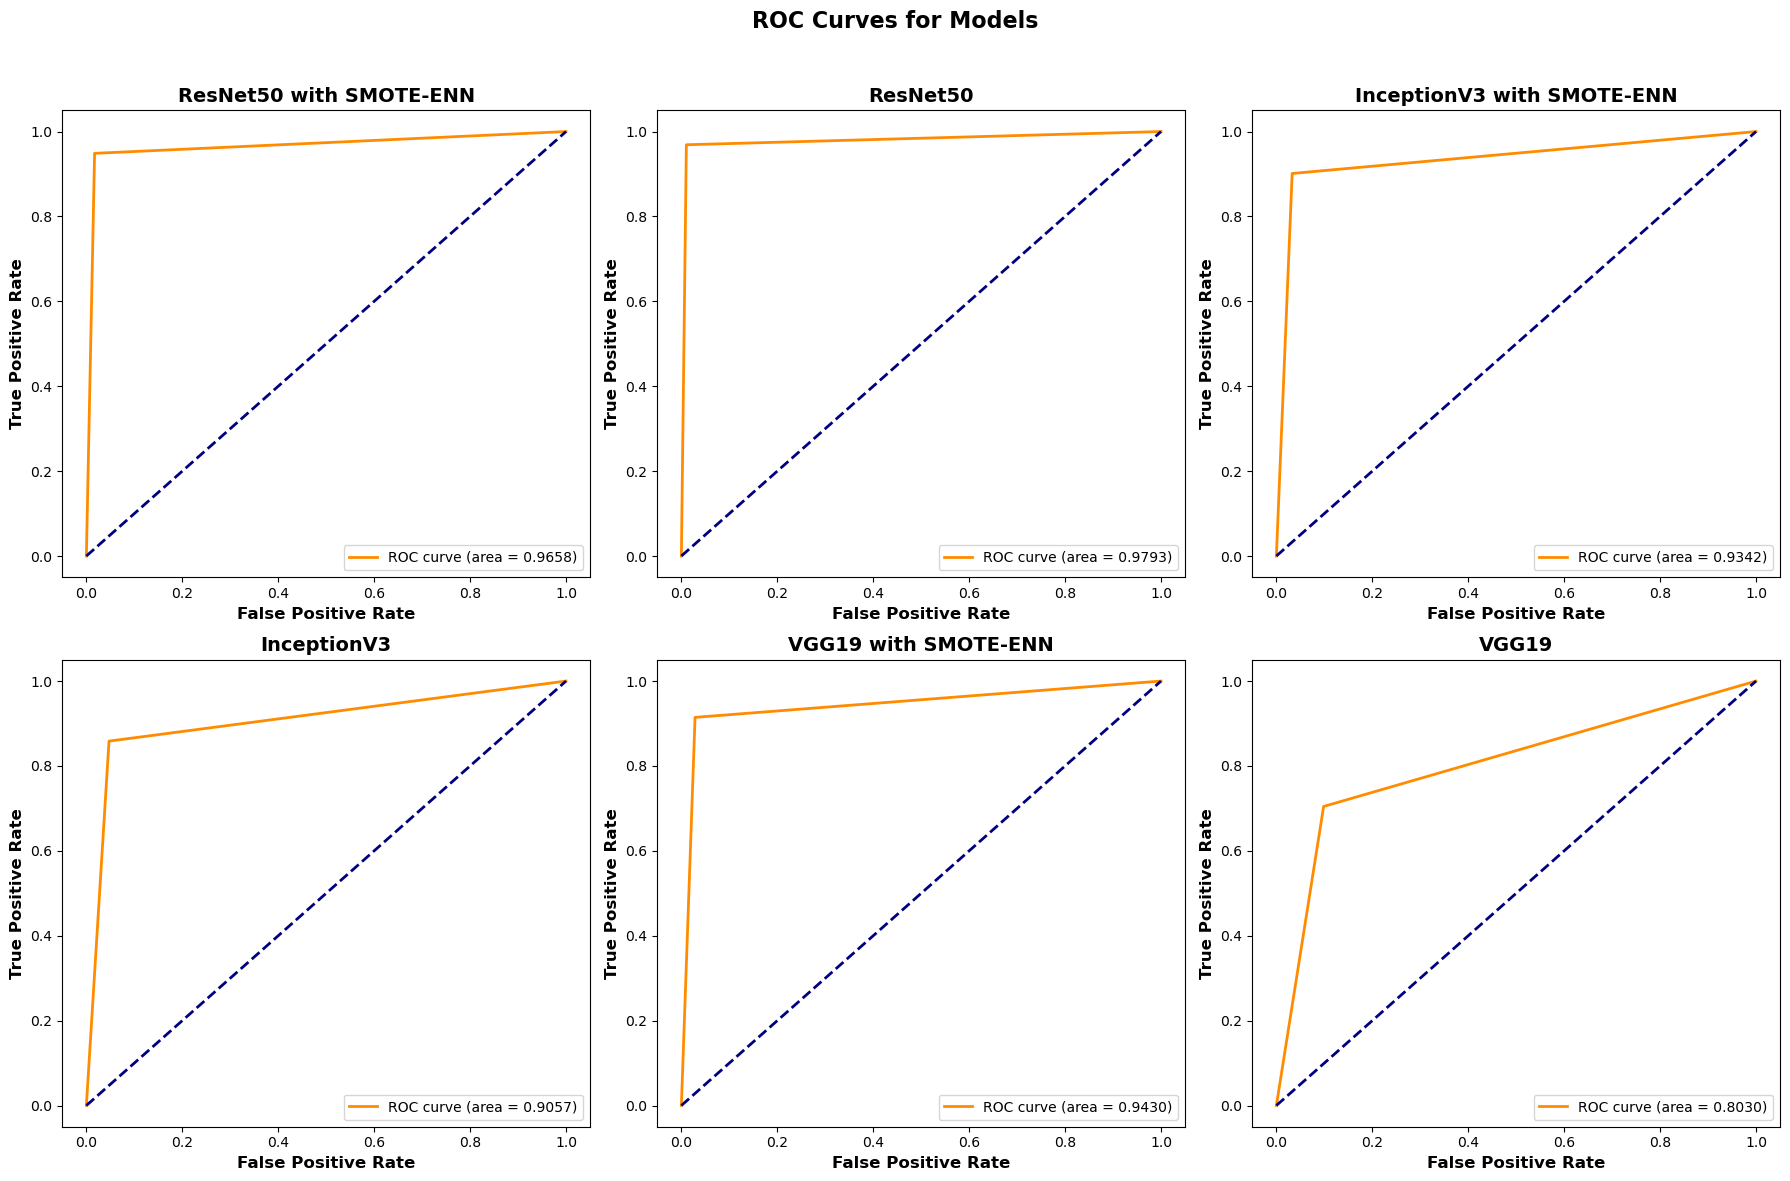

In [55]:
predictions = [
    (RN50_se_pred_labels, "ResNet50 with SMOTE-ENN"),
    (RN50_pred_labels, "ResNet50"),
    (IV3_se_pred_labels, "InceptionV3 with SMOTE-ENN"),
    (IV3_pred_labels, "InceptionV3"),
    (V19_se_pred_labels, "VGG19 with SMOTE-ENN"),
    (V19_pred_labels, "VGG19"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
fig.suptitle("ROC Curves for Models", fontsize=16, fontweight='bold')

# Iterate through predictions and plot ROC curves
for ax, (pred_labels, title) in zip(axes.ravel(), predictions):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curve and AUC for each class
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot the ROC curve for the first class (or use "micro" average)
    ax.plot(
        fpr["micro"], tpr["micro"],
        color="darkorange", lw=2,
        label="ROC curve (area = %0.4f)" % roc_auc["micro"]
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    
    # Set title and labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold')
    ax.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)

# Adjust layout to ensure no overlaps
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()

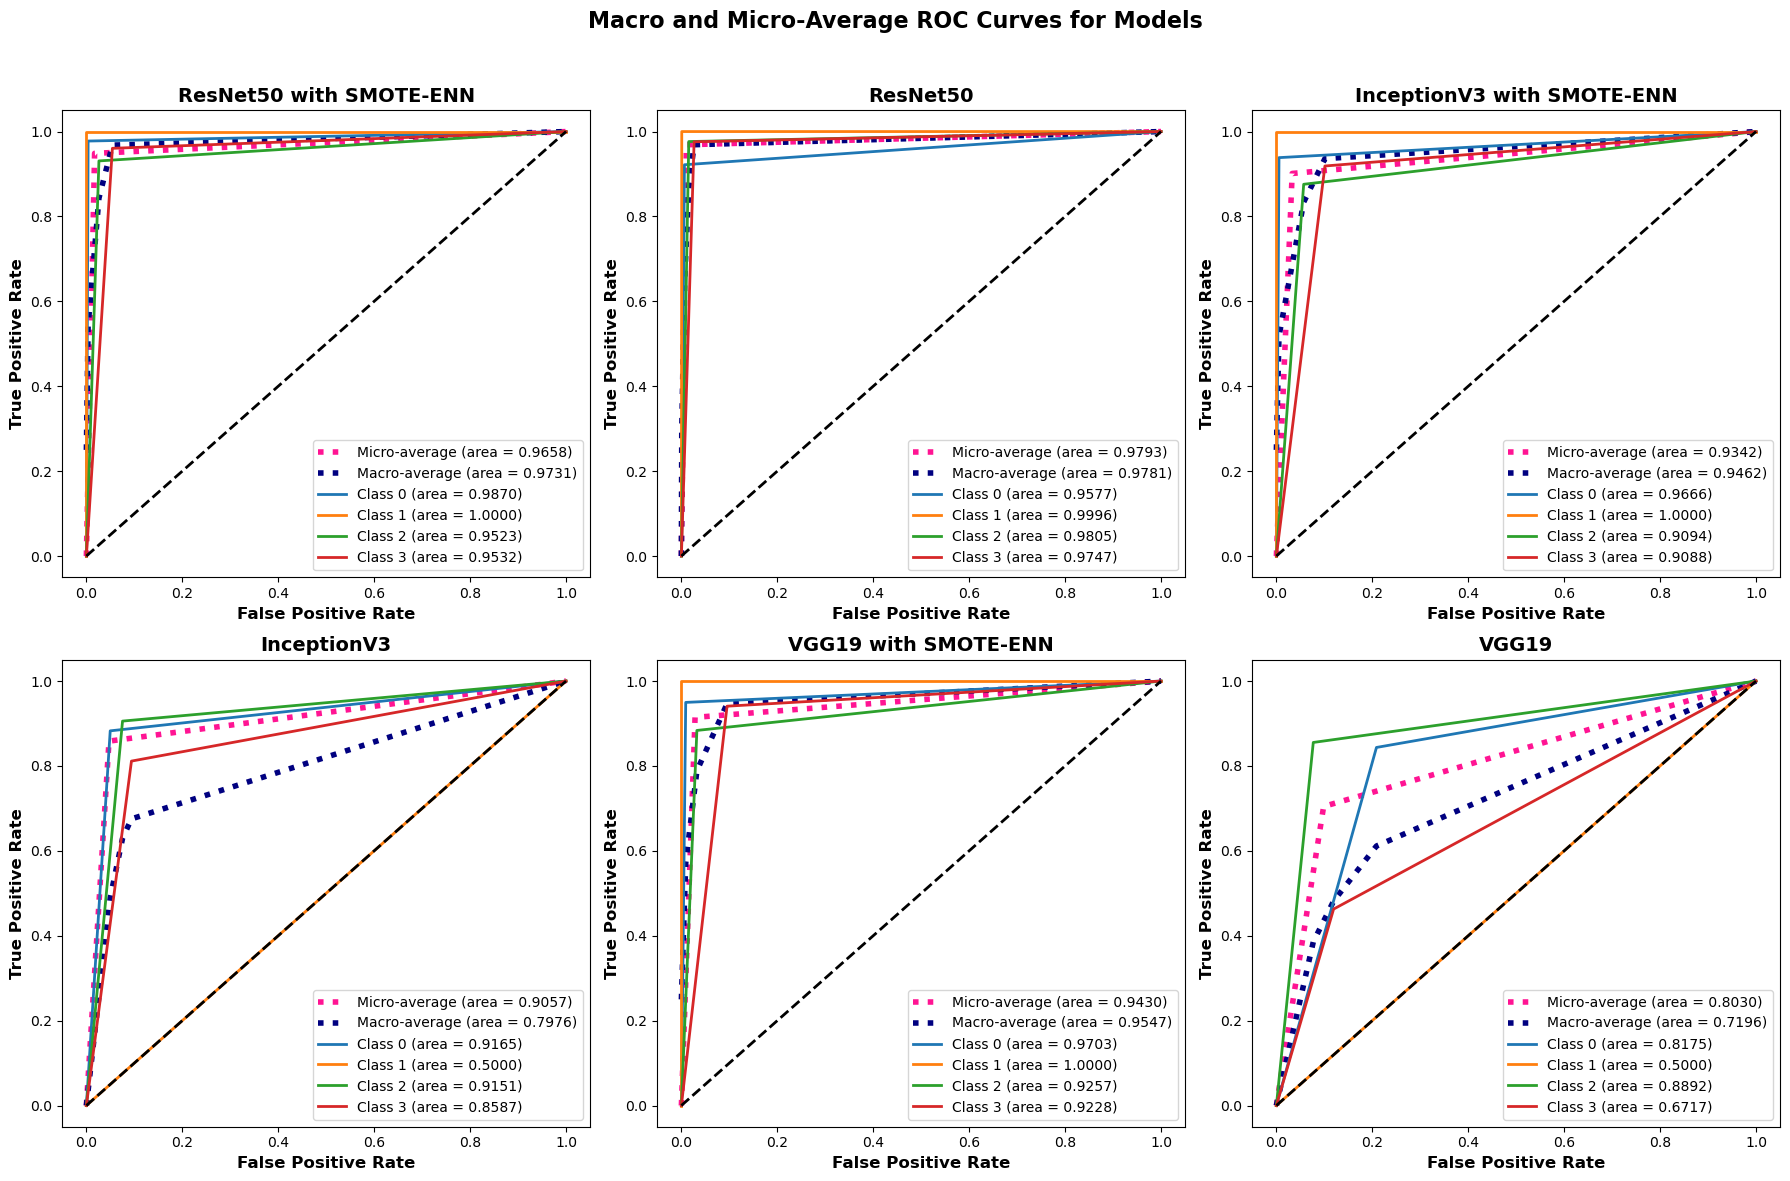

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
fig.suptitle("Macro and Micro-Average ROC Curves for Models", fontsize=16, fontweight='bold')

# Iterate through predictions and plot macro/micro ROC curves
for ax, (pred_labels, title) in zip(axes.ravel(), predictions):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    
    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot macro and micro-average ROC curves
    ax.plot(
        fpr["micro"], tpr["micro"],
        label="Micro-average (area = {0:0.4f})".format(roc_auc["micro"]),
        color="deeppink", linestyle=":", linewidth=4
    )
    ax.plot(
        fpr["macro"], tpr["macro"],
        label="Macro-average (area = {0:0.4f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4
    )
    
    # Plot class-specific ROC curves
    for i in range(n_classes):
        ax.plot(
            fpr[i], tpr[i], lw=2,
            label="Class {0} (area = {1:0.4f})".format(i, roc_auc[i])
        )
    
    # Plot diagonal line for random chance
    ax.plot([0, 1], [0, 1], "k--", lw=2)
    
    # Set title, labels, and legend
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold')
    ax.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)

# Adjust layout to avoid overlaps
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()